In [233]:
import os
import json
import re
import statistics

dataLocation = "../data/"

wordpress = "wordpress"
wordpressNoSymm = "wordpressNoSymm"
quasigroup = "quasigroup"
quasigroupOcc = "quasigroupOcc"
quasigroupBool = "quasigroupBool"
tournament = "tournament"
tournamentFree = "tournamentFree"
mspsp = "mspsp"
cvrptw = "cvrptw"
roster = "roster"
rosterFree = "rosterFree"


stdDevLoc = "stdDev"

optimisations = ["O0_S0", "O2_S0", "O2_S1", "O2_S2", "O3_S0", "O3_S1", "O3_S2"]
dataKeys = ["time", "solveTime", "initTime", "timeout"]
problems = [quasigroup, quasigroupOcc, quasigroupBool, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
noOccProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, tournament, mspsp, cvrptw, rosterFree, roster]
originalProblems = [quasigroup, wordpress, wordpressNoSymm, tournament, mspsp, cvrptw, roster]
freeOriginalProblems = [quasigroup, wordpress, wordpressNoSymm, tournamentFree, mspsp, cvrptw, rosterFree]
freeProblems = [tournamentFree, rosterFree]


eprimePath = "/eprime"
minizincPath = "/minizinc"

def extractNumbers(x):
    temp = re.findall(r'\d+', x)
    temp = list(map(int, temp))
    return temp[0]

def runVals(x, indx):
    return [i[indx] for i in x]

def getData(path, isEprime):
    runs = []
    for entry in os.scandir(path):
        if os.path.isdir(entry):
            continue
        f = open(entry)
        data = json.load(f)
        if isEprime:
            data = processEprime(data)
        # case of unknown message, ex. quasigroupOcc.mzn run on instance 50.json
        if not isEprime and 'time' not in data:
            data["timeout"] = True
            data["initTime"] = 0.5 # dummy value
        if data["timeout"]:
            data["solveTime"] = timeoutTimeSecs
            data["time"] = timeoutTimeSecs
        runs.append(data)
        f.close()
    res = {}
    if len(runs) > 0:
        lstSort = [tuple(ind[i] for i in dataKeys) for ind in runs]
        sortedLst = sorted(lstSort)
        mid = sortedLst[1]
        for i in range(len(dataKeys)):
            res[dataKeys[i]] = mid[i]
        res[stdDevLoc] = statistics.stdev([rn["time"] for rn in runs])
    return res

def processEprime(data):
    d = {}
    d["time"] = data['SolverTotalTime'] + data['SavileRowTotalTime']
    d["solveTime"] = data['SolverTotalTime']
    d["initTime"] = data['SavileRowTotalTime']
    d["timeout"] = data['SolverTimeOut'] == 1

    return d
    
# hypothesis the generated data is supported by Eprime search given instances were found using Eprime

timeoutTimeSecs = 300

eprimeData = {}
minizincData = {}

for i in problems:
    problemLocation = dataLocation + i
    opt = {}
    for optimize in os.scandir(problemLocation + eprimePath):
        res = []
        for problem in os.scandir(optimize.path):
            res.append((problem.name, getData(problem.path, True)))
        opt[optimize.name] = res
    eprimeData[i] = opt

    res = []
    for problem in os.scandir(problemLocation + minizincPath):
        if os.path.isdir(problem.path):
            res.append((problem.name, getData(problem.path, False)))
    minizincData[i] = res


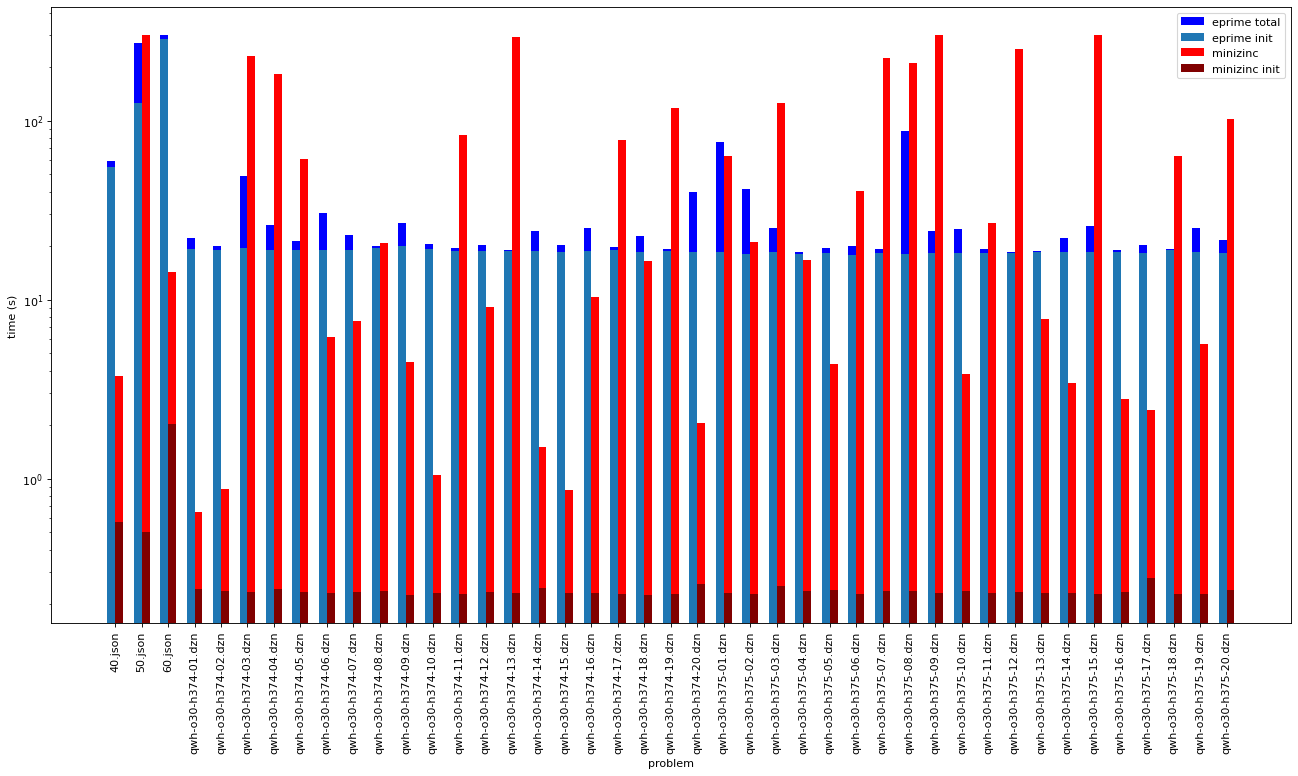

In [234]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

def getData(dataToExtract):
    # print(dataToExtract)
    xData, yData = zip(*sorted(dataToExtract))
    yTime =  list(map(lambda x : x["time"], yData))
    yInit = list(map(lambda x : x["initTime"], yData))
    ySolverTime = list(map(lambda x : x["solveTime"], yData))
    yCompleted = list(map(lambda x : x["timeout"], yData))
    yDeviation = list(map(lambda x : x[stdDevLoc], yData))
    return (xData, yTime, ySolverTime, yInit, yCompleted, yDeviation)



eprimeX, eprimeTime, eprimeSolverTime, eprimeInit, eprimeCompleted, eprimeStd = getData(eprimeData[quasigroupOcc]["O0_S0"])
minizincX, minizincTime, minizincSolverTime, minizincInit, minizincCompleted, minizincStd = getData(minizincData[quasigroupOcc])
# minizincX, minizincTime, minizincInit, minizincCompleted = getData(eprimeData[quasigroup]["O0_S0"])
# eprimeCseX, eprimeCseTime, eprimeCseInit = getData(eprimeCseData[wordpress])

# print(set(minizincX).difference(set(eprimeX)))
# print(set(eprimeX).difference(set(minizincX)))
# print(len(eprimeX))
# print(len(minizincX))

# if isWordpress:
eprimeX = list(map(str, eprimeX))
minizincX = list(map(str, minizincX))

ind = np.arange(len(eprimeX))
width = 0.3

figure(figsize=(20, 10), dpi=80)
# plt.bar(ind-width, eprimeCseTime, width, label="eprime x-cse total", color="blue")
# plt.bar(ind-width, eprimeCseInit, width, label="eprime x-cse init")
plt.bar(ind, eprimeTime, width, label="eprime total", color="blue")
plt.bar(ind, eprimeInit, width, label="eprime init")
plt.bar(ind+width, minizincTime, width, label="minizinc", color="red")
plt.bar(ind+width, minizincInit, width, label="minizinc init" , color="maroon")
# plt.scatter(eprimeX, eprimeY, label="eprime")
# plt.scatter(minizincX, minizincY, label="minizinc")
plt.legend(loc="best")
plt.xticks(ind+width/2, minizincX)
plt.xticks(rotation = 90)
plt.xlabel("problem")
plt.ylabel("time (s)")
plt.yscale("log")

quasigroup
quasigroupOcc
quasigroupBool
wordpress
wordpressNoSymm
tournamentFree
tournament
mspsp
cvrptw
rosterFree
roster


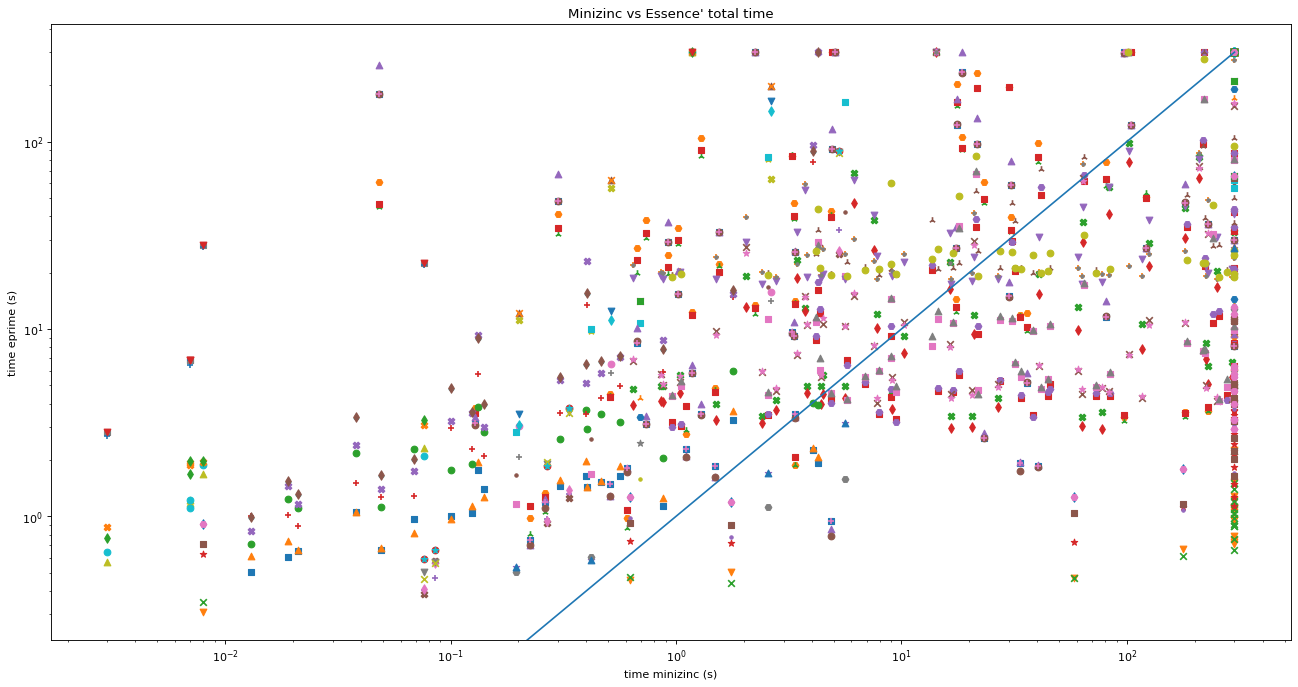

In [235]:
import itertools

allEprimeTimings = {}
allMinizincTimings = {}

titleNames = ["", "total time", "solver time", "initialization time", "standard deviation time"]

problemIndex = 0
timingIndex = 1
solverTimeIndex = 2
initIndex = 3
timeoutIndex = 4
stdDevIndex = 5

for i in problems:
    print(i)
    allMinizincTimings[i] = getData(minizincData[i])
    allEprimeTimings[i] = {}
    for j in optimisations:
        allEprimeTimings[i][j] = getData(eprimeData[i][j])

marker = itertools.cycle((',', '+', '.', 'o', '*', '^', 'x', 's', 'v','2', 'd', 'H', 'X'))

# for i in problems:
#     plt.scatter(allMinizincTimings[i][timingIndex], allMinizincTimings[i][timingIndex], label="minizinc_"+i)
#     for j in optimisations:
#         plt.scatter(allEprimeTimings[i][j][timingIndex], allEprimeTimings[i][j][timingIndex], label=i + "_" + j)

def setupPlotSolverSolver(graphTitle="Minizinc vs Essence'", indexOfInterest=timingIndex):
    figure(figsize=(20, 10), dpi=80)
    plt.plot([0, timeoutTimeSecs], [0, timeoutTimeSecs])
    plt.xlabel("time minizinc (s)")
    plt.ylabel("time eprime (s)")
    plt.yscale("log")
    plt.xscale("log")
    plt.title(graphTitle + " " + titleNames[indexOfInterest])

# wordpress timingIndex, timing out
# tournament timingIndex, notably only 20f, 20h
# roster timingIndex, timing out
# cvrptw everything times out
# mspsp out-performed by minizinc on init and solver time
# quasigroup, all over the place

def createOccurencePlot(opt, occProblem, explicitProblem, annotate=False, indexOfInterest=timingIndex):
    x, y = occProblem[indexOfInterest], explicitProblem[indexOfInterest]
    plt.xlabel("time occurrence (s)")
    plt.ylabel("time explicit (s)")
    plt.scatter(x, y, label= quasigroup + " " + opt, marker=next(marker))
    if annotate:
        for j in range(len(occProblem[problemIndex])):
            plt.annotate(occProblem[problemIndex][j], (occProblem[indexOfInterest][j], explicitProblem[indexOfInterest][j]))



def createPlot(opt, problemList, annotate=False, errorbars=False, indexOfInterest=timingIndex):
    for i in problemList:
        minizincProblem = allMinizincTimings[i]
        essenceProblem = allEprimeTimings[i][opt]
        # print(set(allMinizincTimings[i][problemIndex]).difference(set(allEprimeTimings[i][opt][problemIndex])))
        # print(set(allEprimeTimings[i][opt][problemIndex]).difference(set(allMinizincTimings[i][problemIndex])))
        x, y = minizincProblem[indexOfInterest], essenceProblem[indexOfInterest]
        plt.scatter(x, y, label= i + " " + opt, marker=next(marker))
        if errorbars:
            plt.errorbar(x, y, yerr=essenceProblem[stdDevIndex], xerr=minizincProblem[stdDevIndex], ls='none')
        if annotate:
            for j in range(len(minizincProblem[problemIndex])):
                plt.annotate(minizincProblem[problemIndex][j], (minizincProblem[indexOfInterest][j], essenceProblem[indexOfInterest][j]))
    if len(problemList) == 1:
        plt.title("Minizinc vs Essence' " + problemList[0] + " " + titleNames[indexOfInterest])

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, problems)
# box = plt.get_position()
# plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(loc="best")

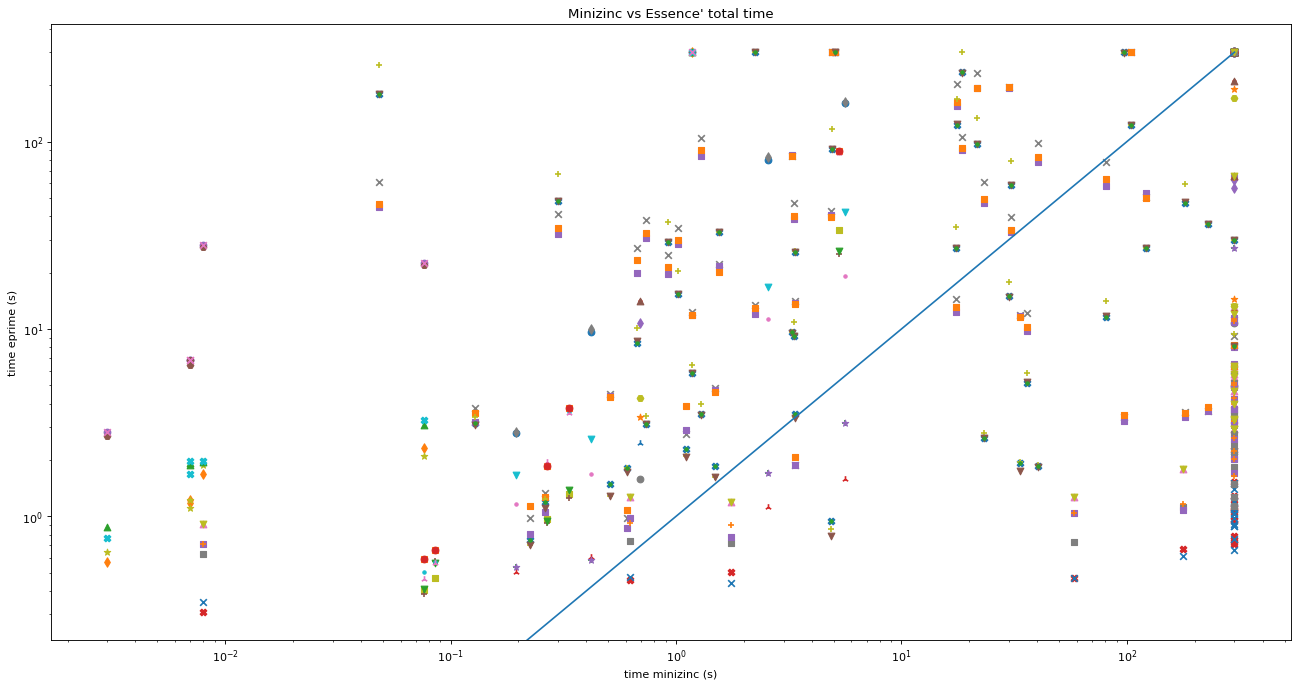

In [236]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, originalProblems)
# plt.legend(loc="best")

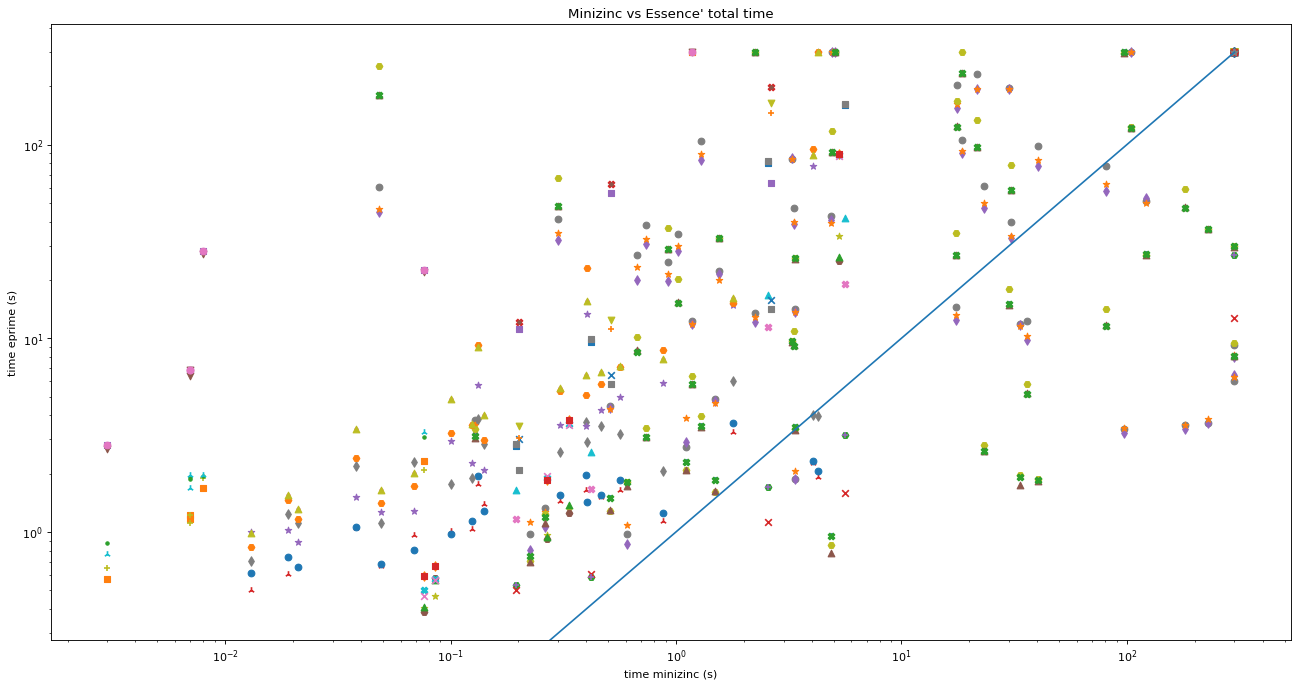

In [237]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, freeOriginalProblems)
# plt.legend(loc="best")

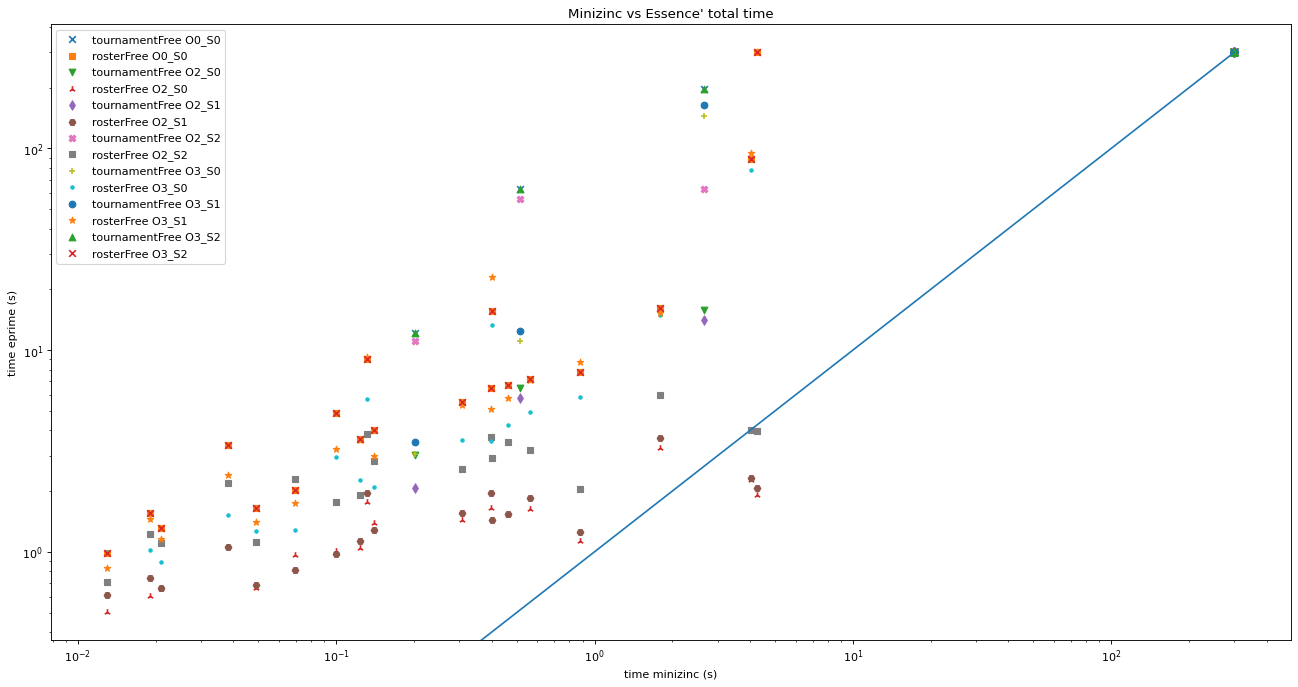

In [238]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, freeProblems)
plt.legend(loc="best")

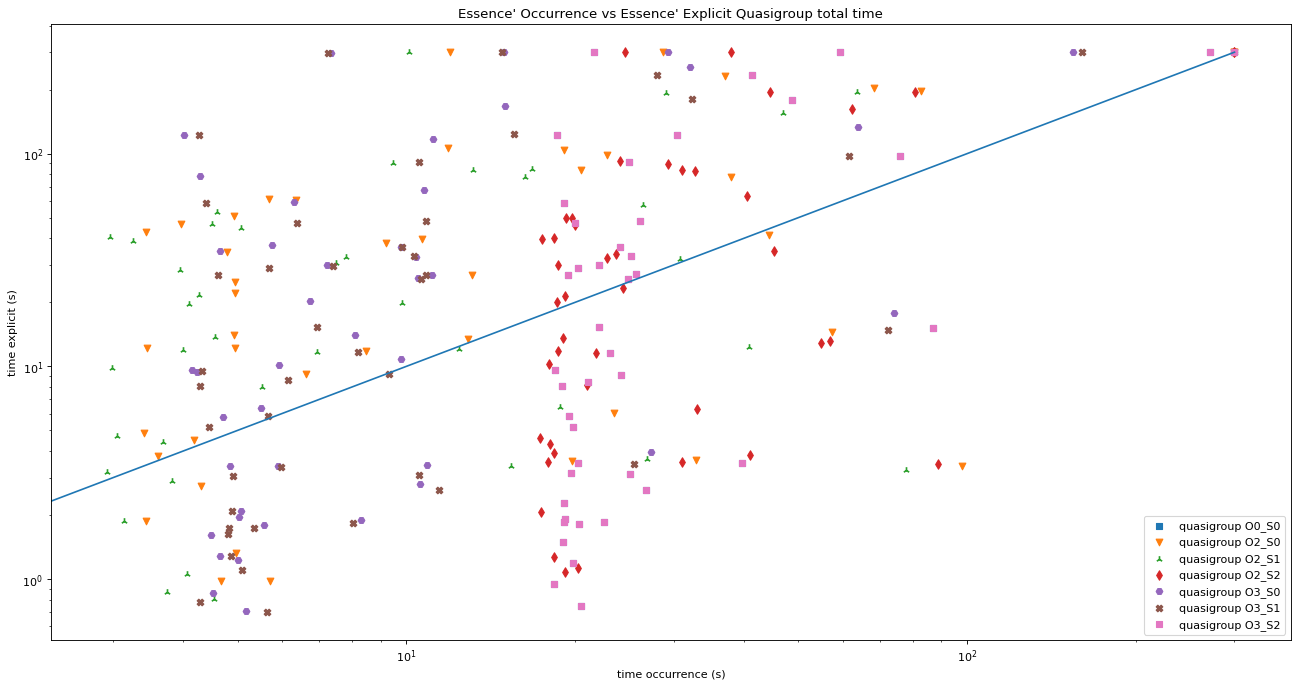

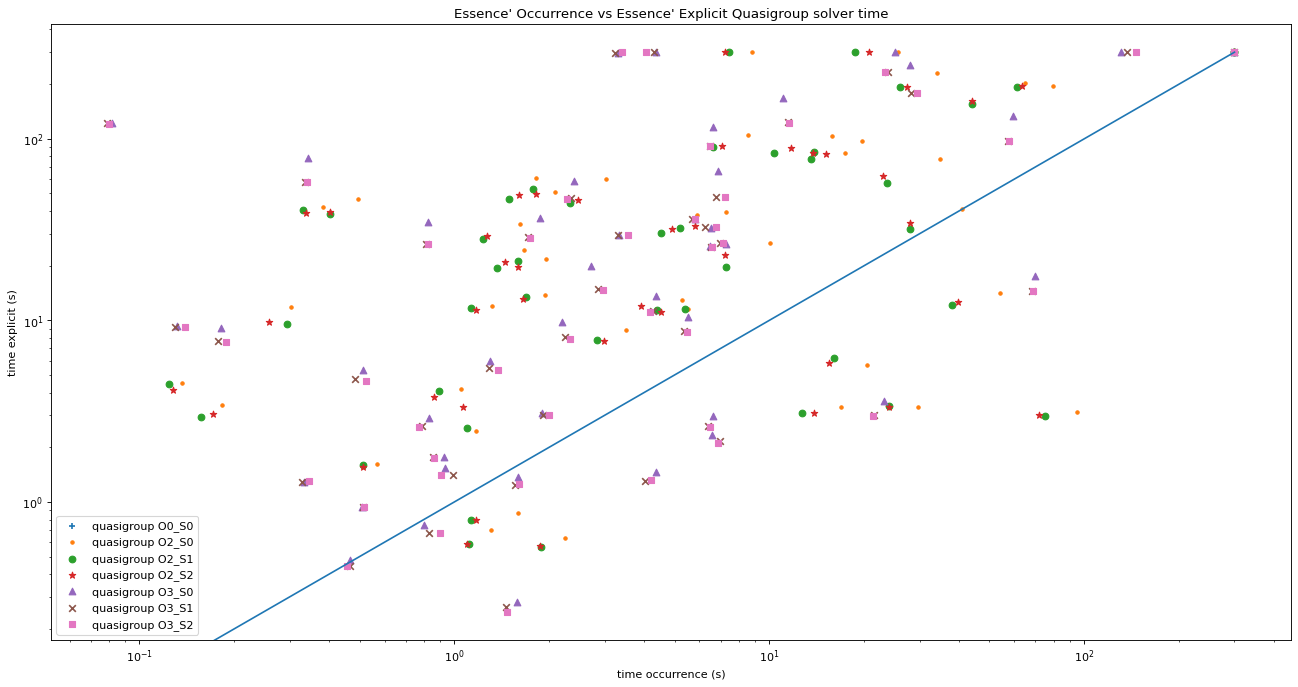

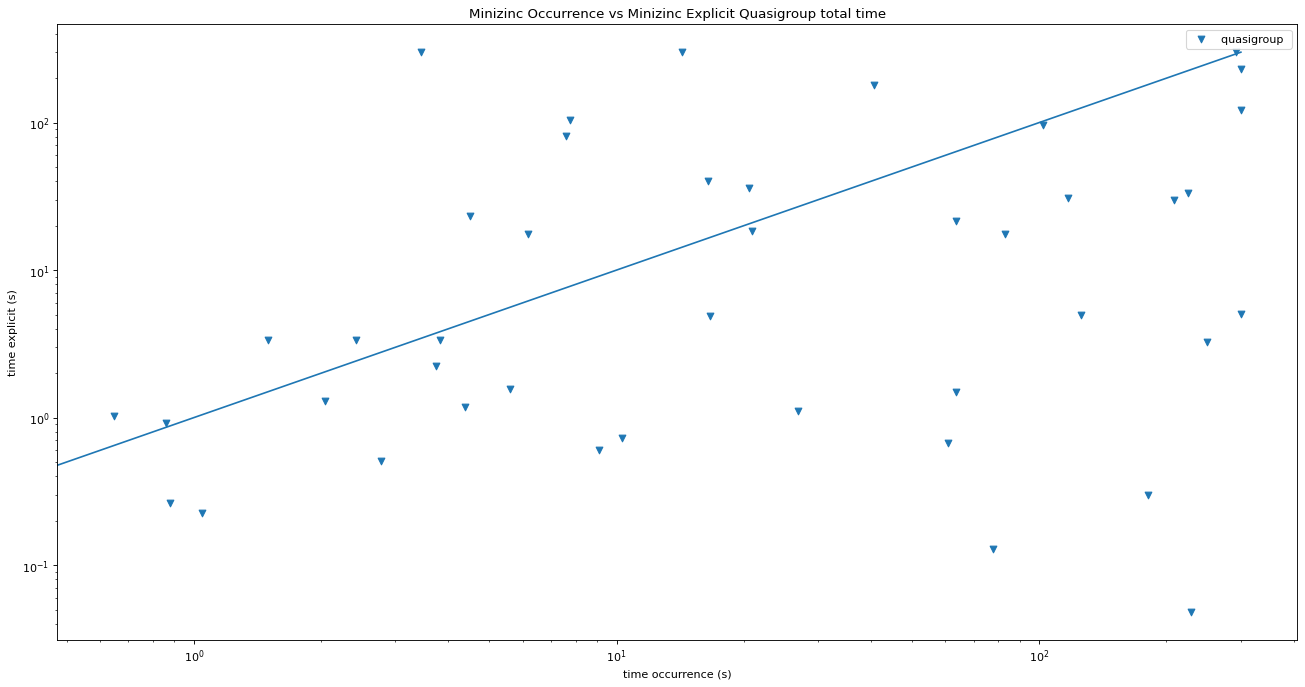

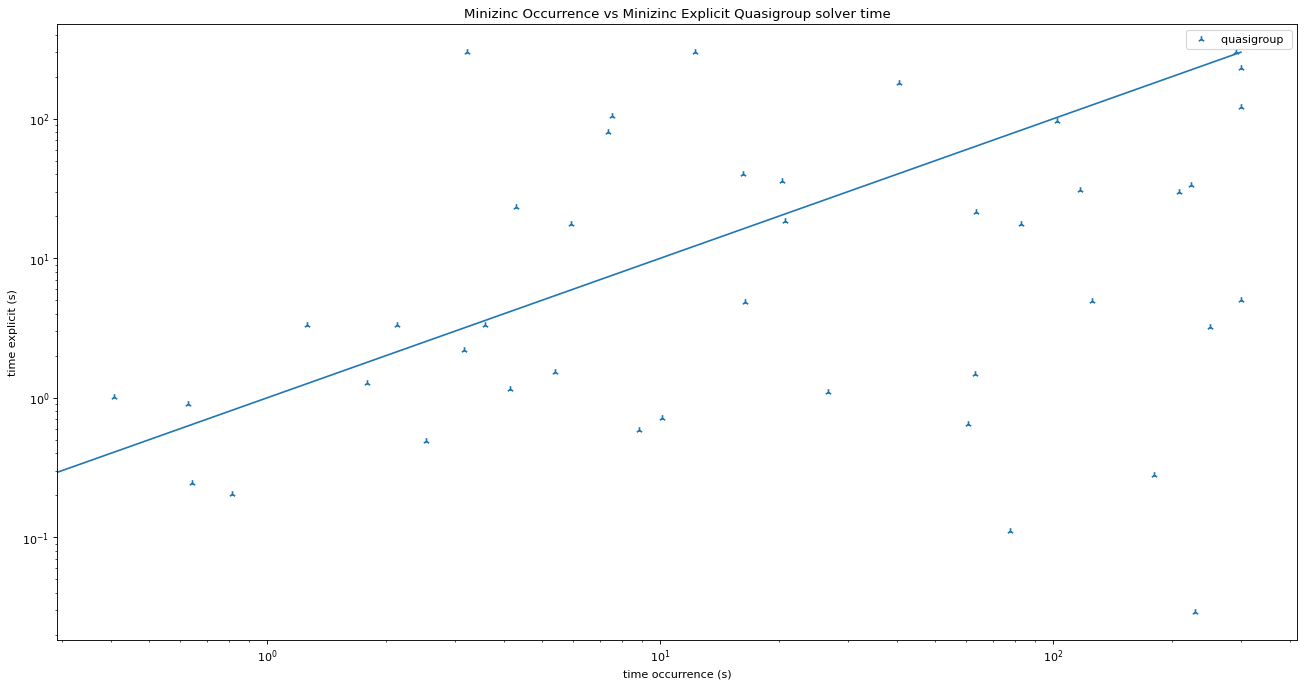

In [239]:
setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup")
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j])
plt.legend(loc="best")

setupPlotSolverSolver("Essence' Occurrence vs Essence' Explicit Quasigroup", solverTimeIndex)
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allEprimeTimings[quasigroup][j], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")

setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup")
createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup])
plt.legend(loc="best")


setupPlotSolverSolver("Minizinc Occurrence vs Minizinc Explicit Quasigroup", solverTimeIndex)
createOccurencePlot("", allMinizincTimings[quasigroupOcc], allMinizincTimings[quasigroup], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")


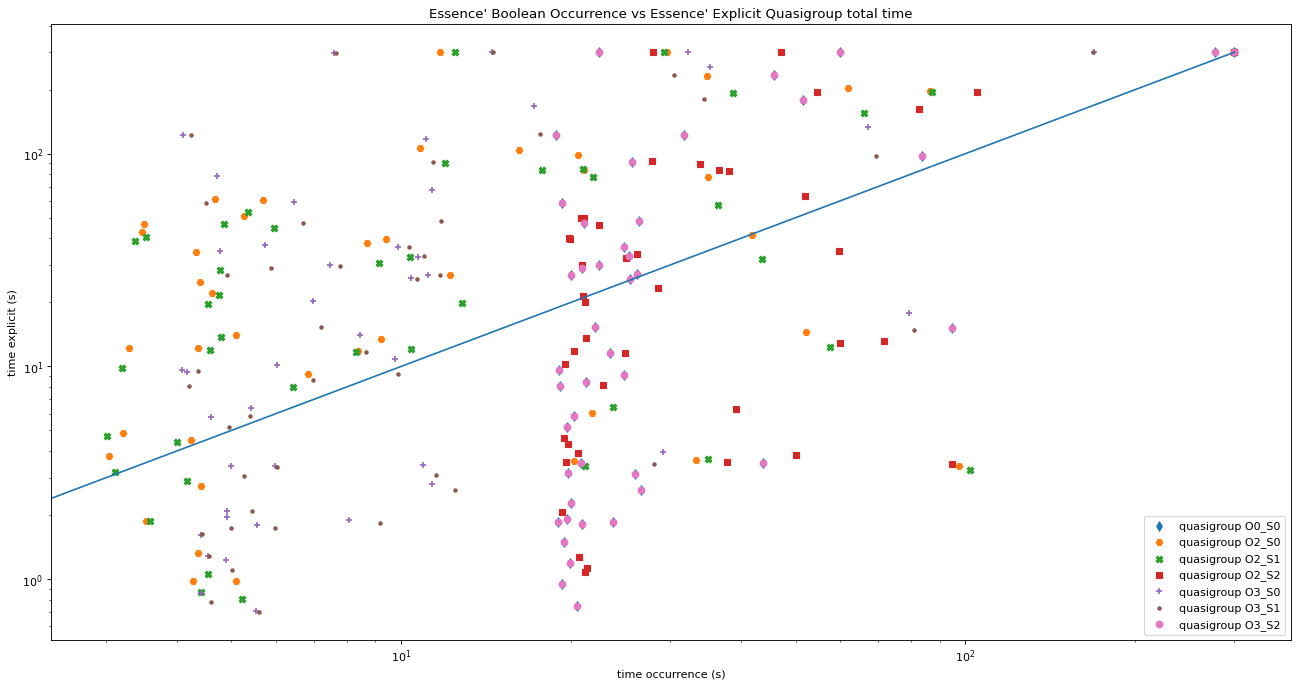

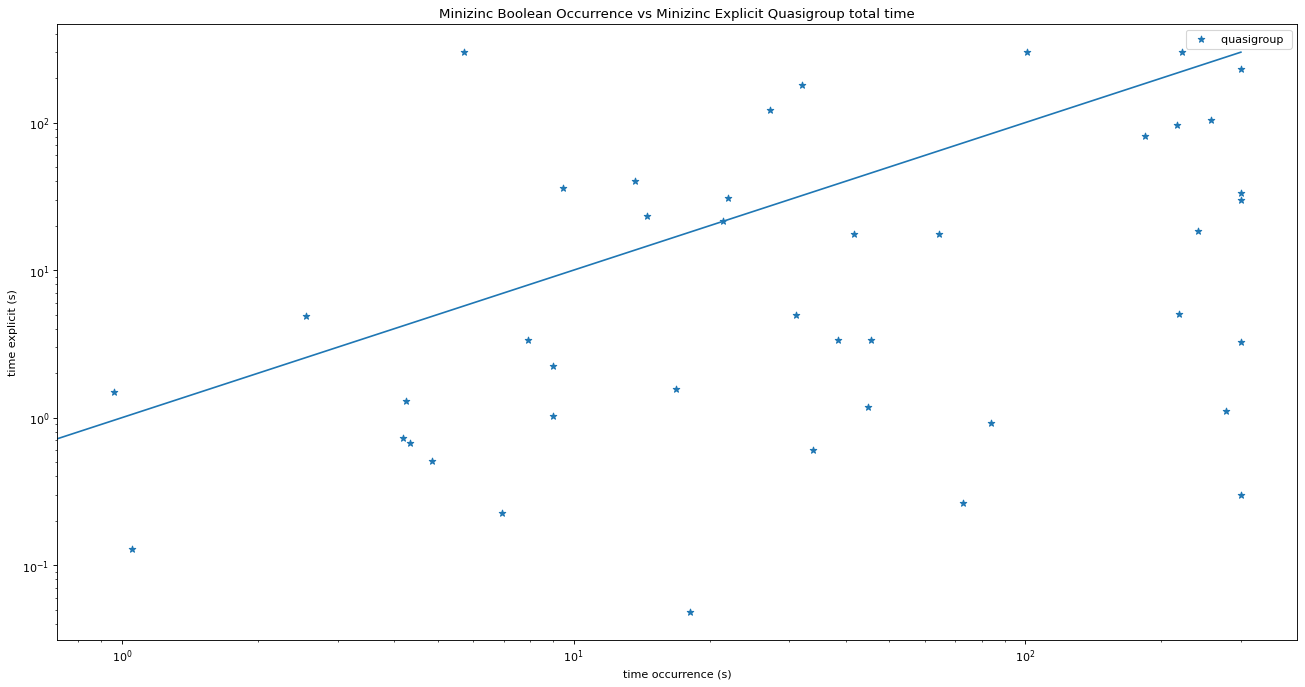

In [240]:
setupPlotSolverSolver("Essence' Boolean Occurrence vs Essence' Explicit Quasigroup")
for j in optimisations:
# for j in ["O2_S1"]:
    createOccurencePlot(j, allEprimeTimings[quasigroupBool][j], allEprimeTimings[quasigroup][j])
# createOccurencePlot("O2_S1")
plt.legend(loc="best")

setupPlotSolverSolver("Minizinc Boolean Occurrence vs Minizinc Explicit Quasigroup")
createOccurencePlot("", allMinizincTimings[quasigroupBool], allMinizincTimings[quasigroup])
plt.legend(loc="best")

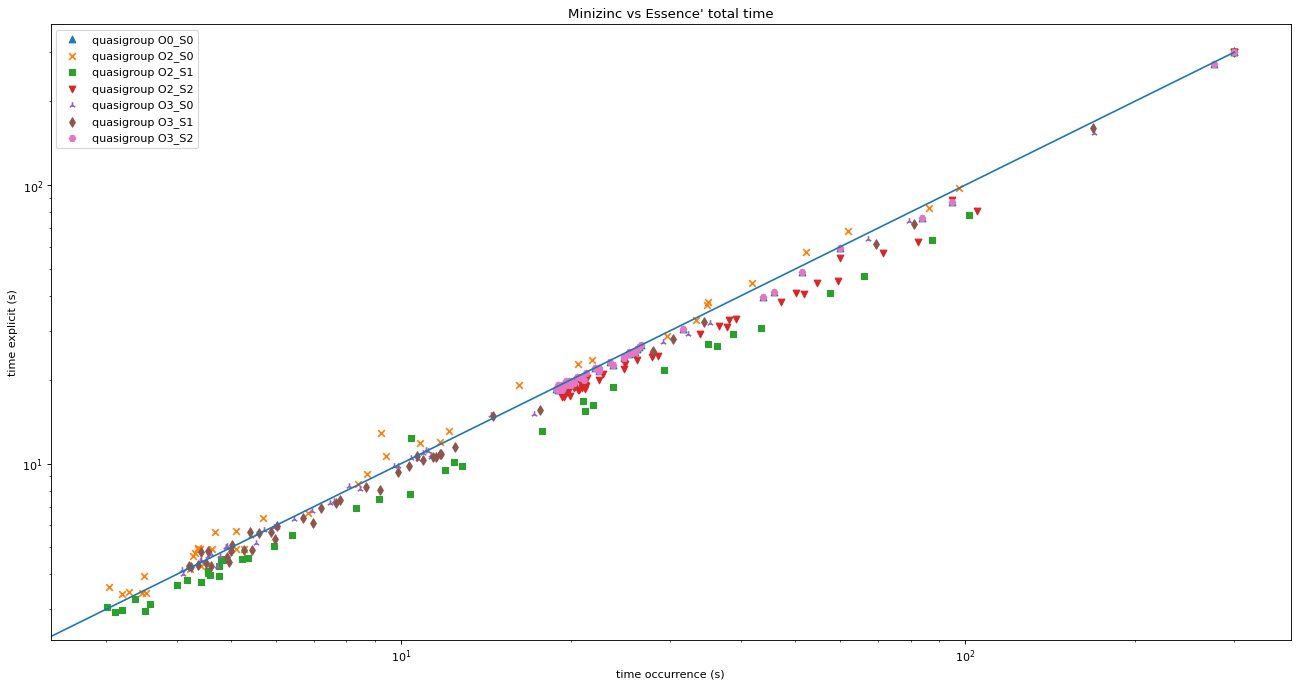

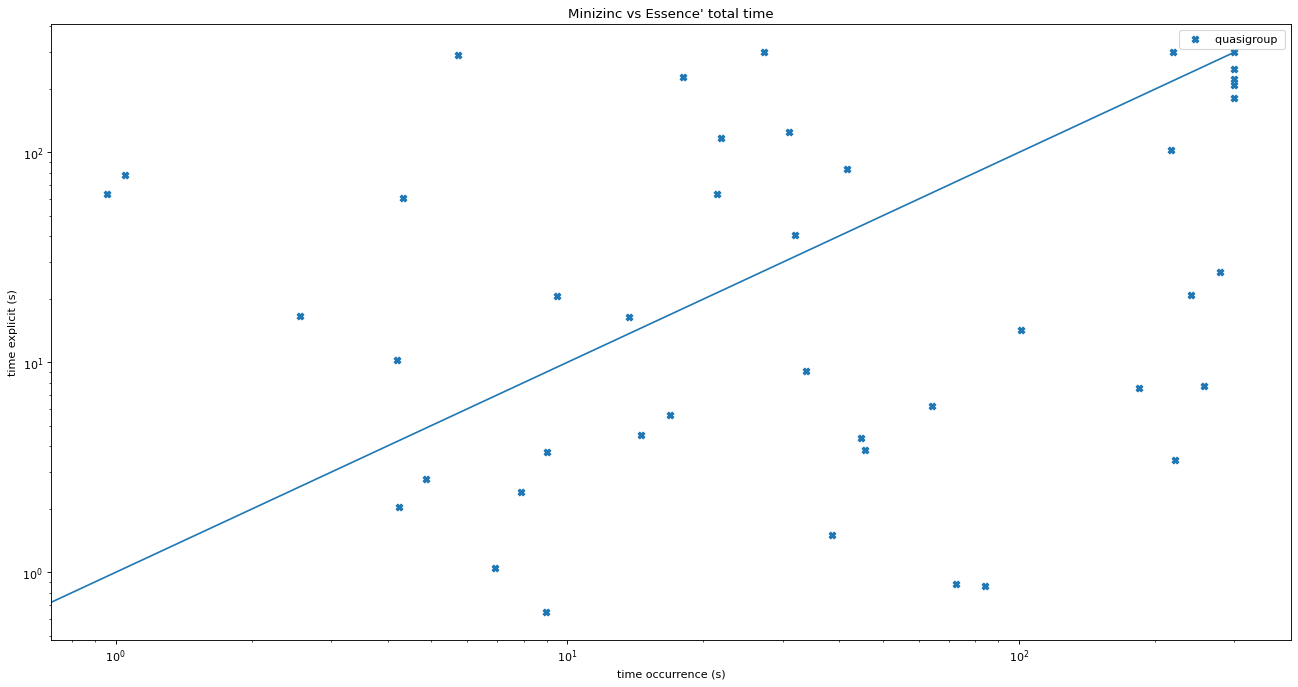

In [241]:
setupPlotSolverSolver()
for j in optimisations:
# for j in ["O2_S1"]:
    createOccurencePlot(j, allEprimeTimings[quasigroupBool][j], allEprimeTimings[quasigroupOcc][j])
# createOccurencePlot("O2_S1")
plt.legend(loc="best")

setupPlotSolverSolver()
createOccurencePlot("", allMinizincTimings[quasigroupBool], allMinizincTimings[quasigroupOcc])
plt.legend(loc="best")

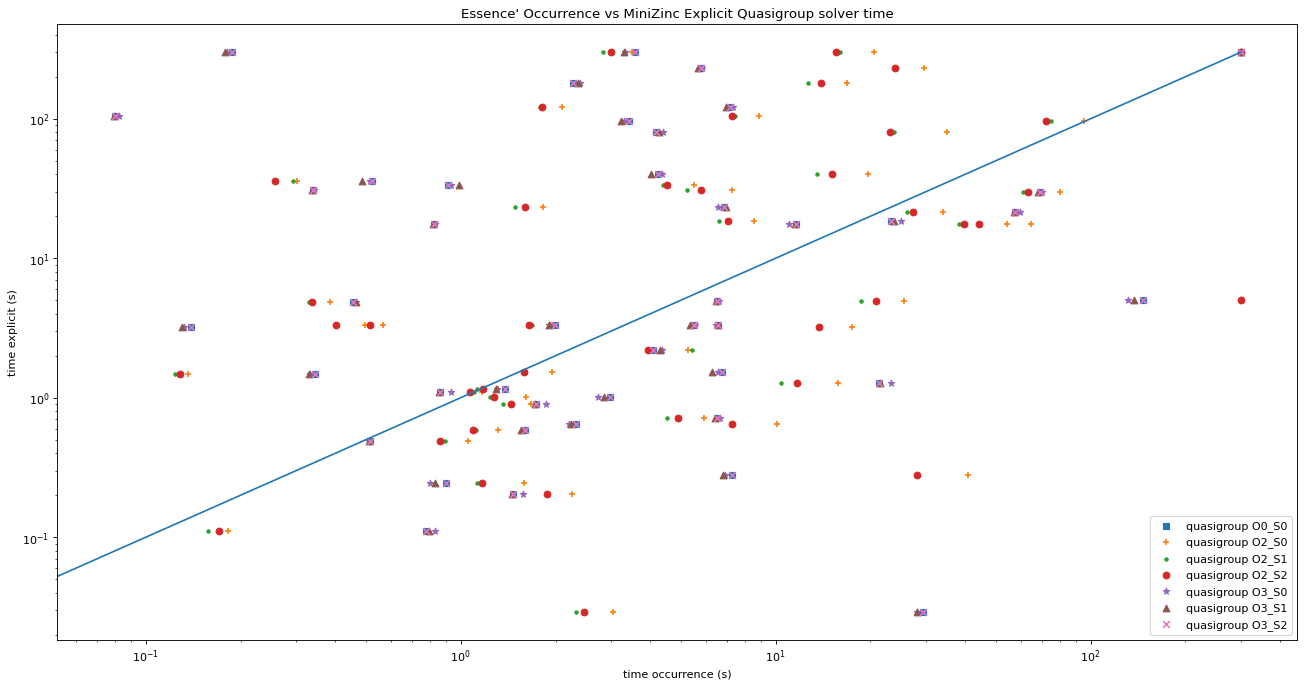

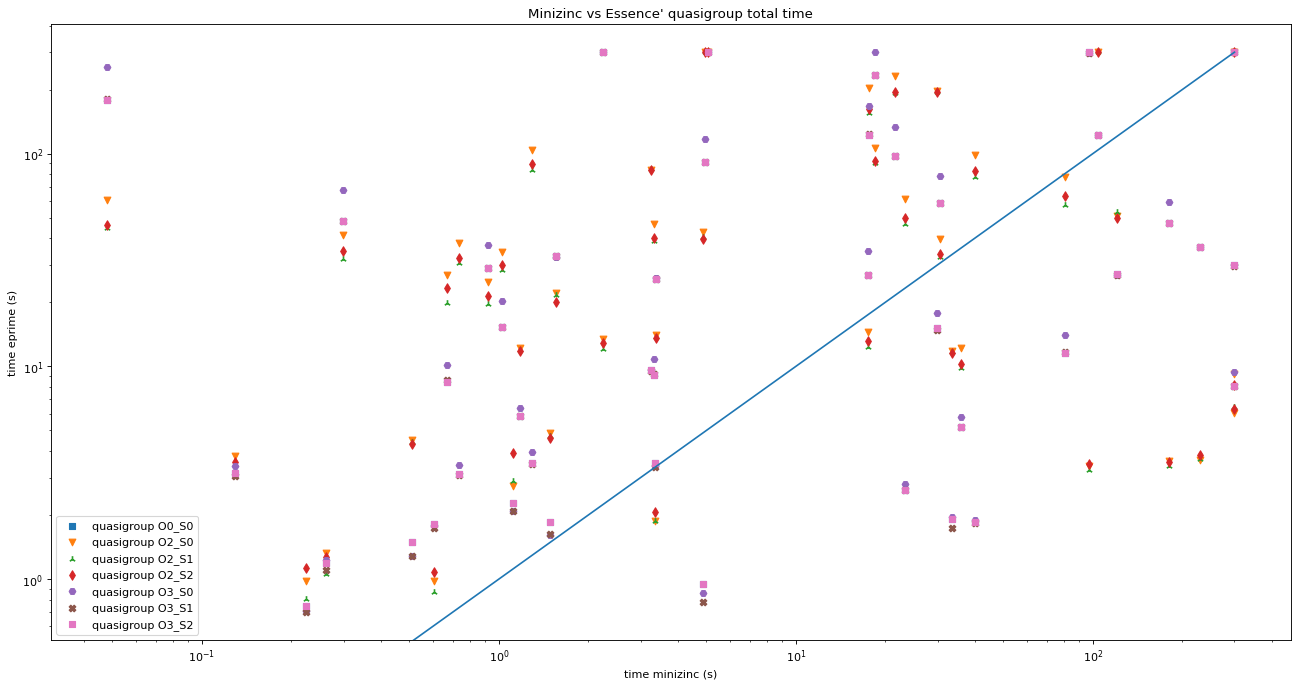

In [242]:
setupPlotSolverSolver("Essence' Occurrence vs MiniZinc Explicit Quasigroup", solverTimeIndex)
for j in optimisations:
    createOccurencePlot(j, allEprimeTimings[quasigroupOcc][j], allMinizincTimings[quasigroup], indexOfInterest=solverTimeIndex)
plt.legend(loc="best")

setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroup])
plt.legend(loc="best")

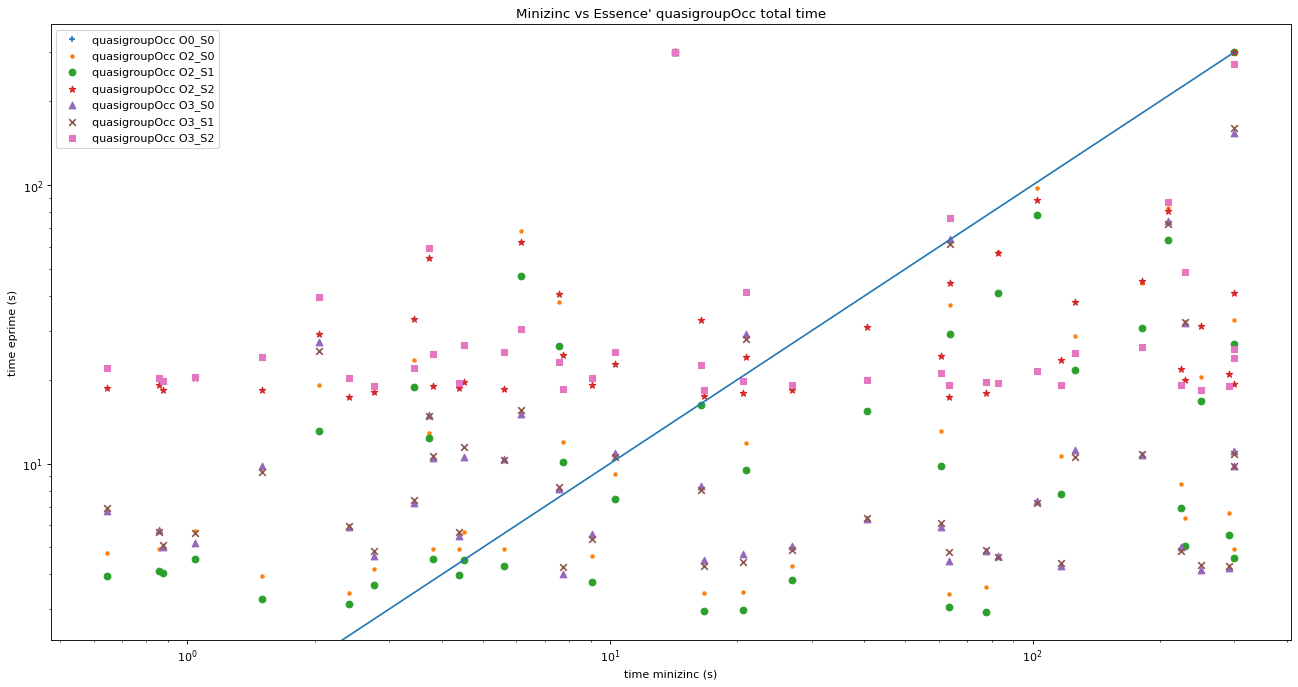

In [243]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [quasigroupOcc])
plt.legend(loc="best")

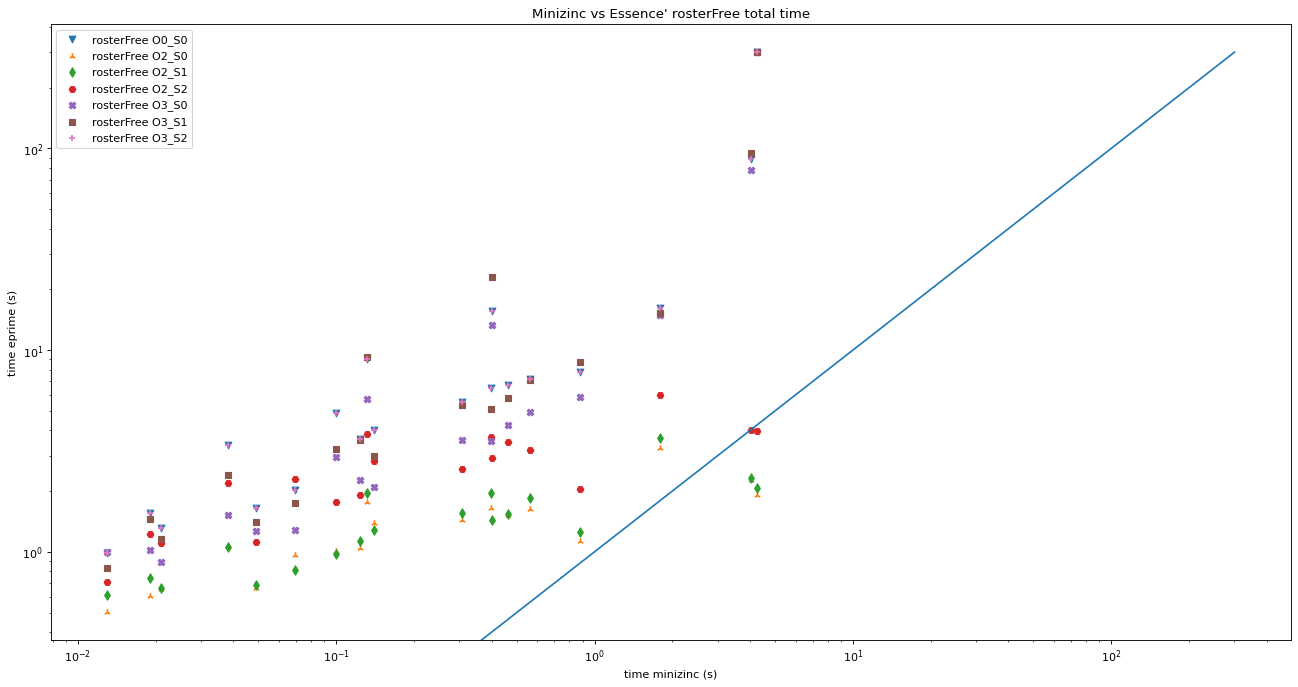

In [244]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [rosterFree])
plt.legend(loc="best")

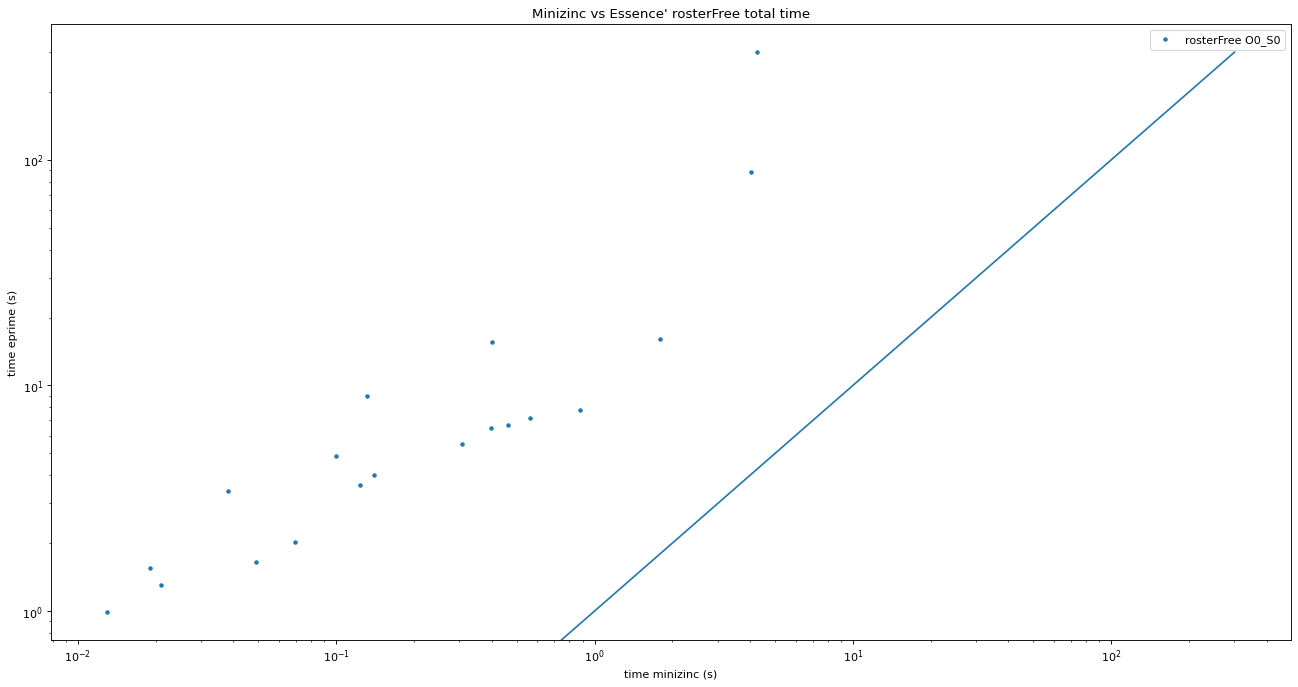

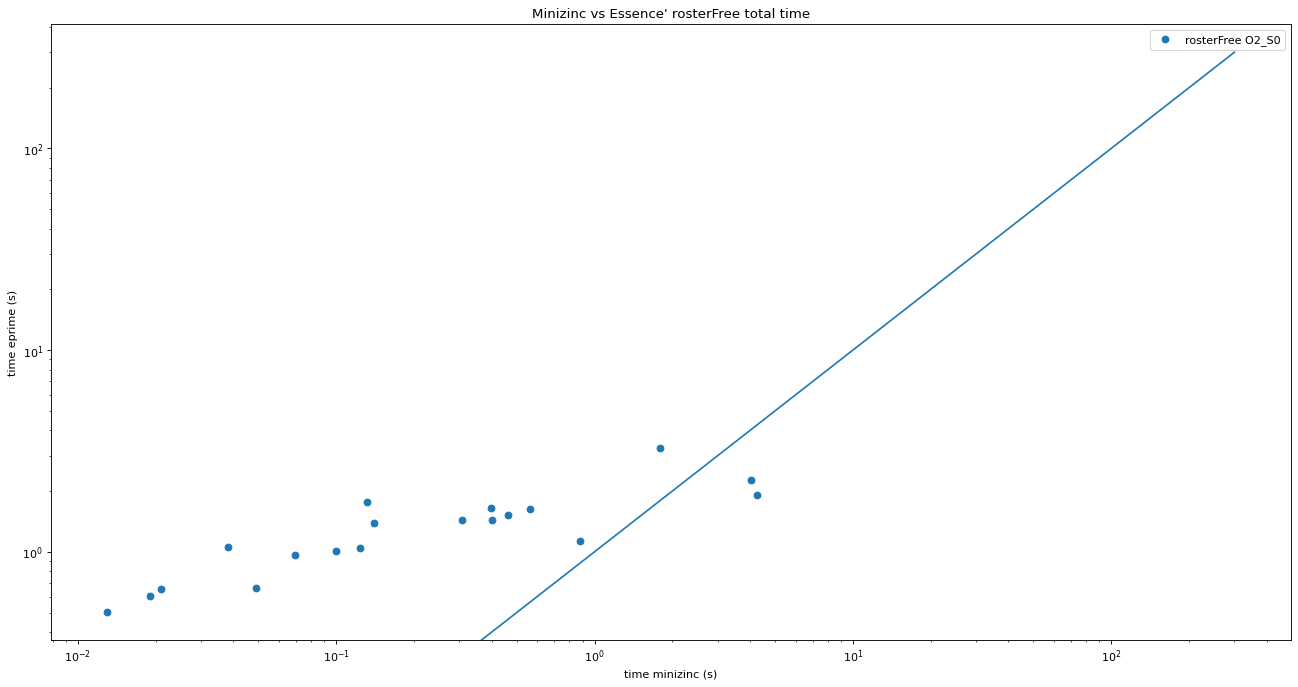

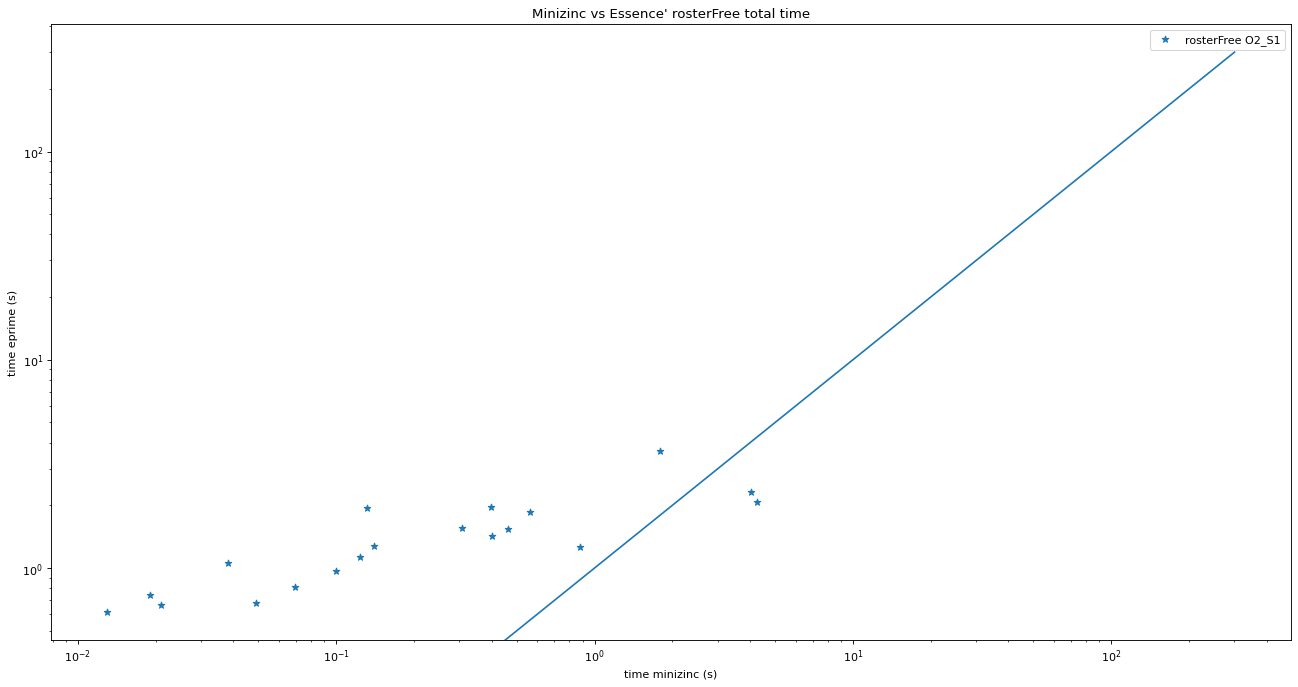

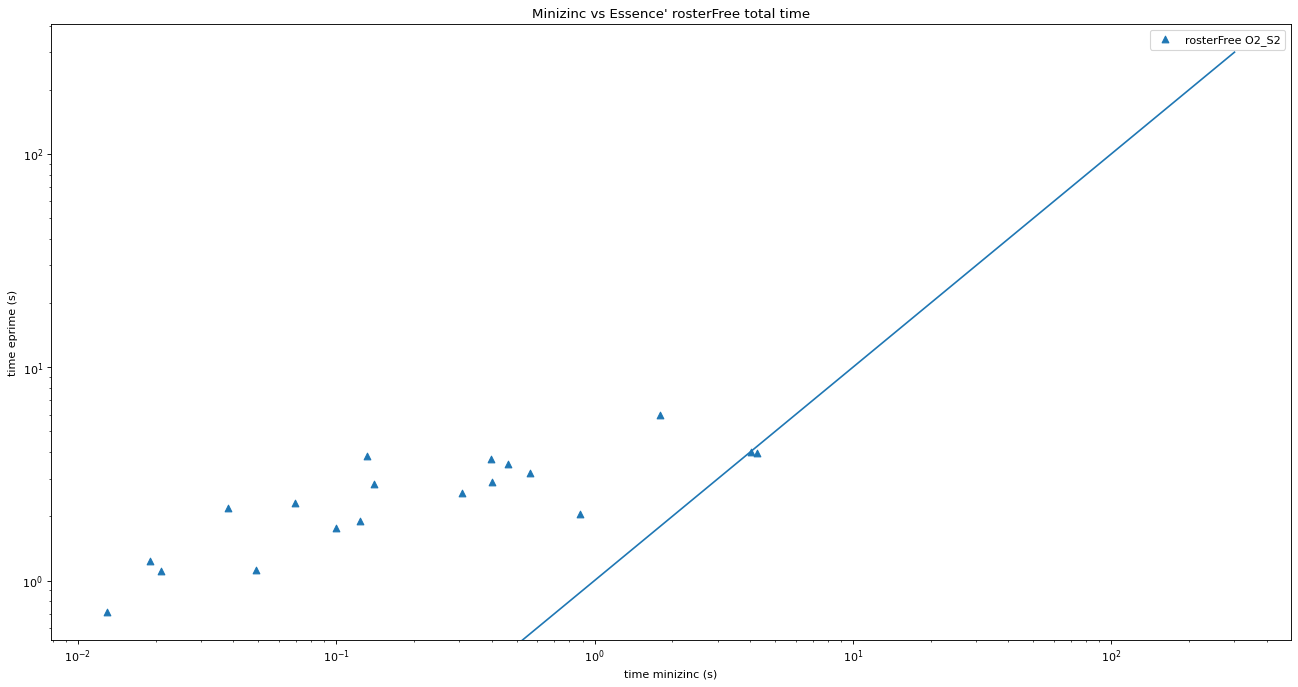

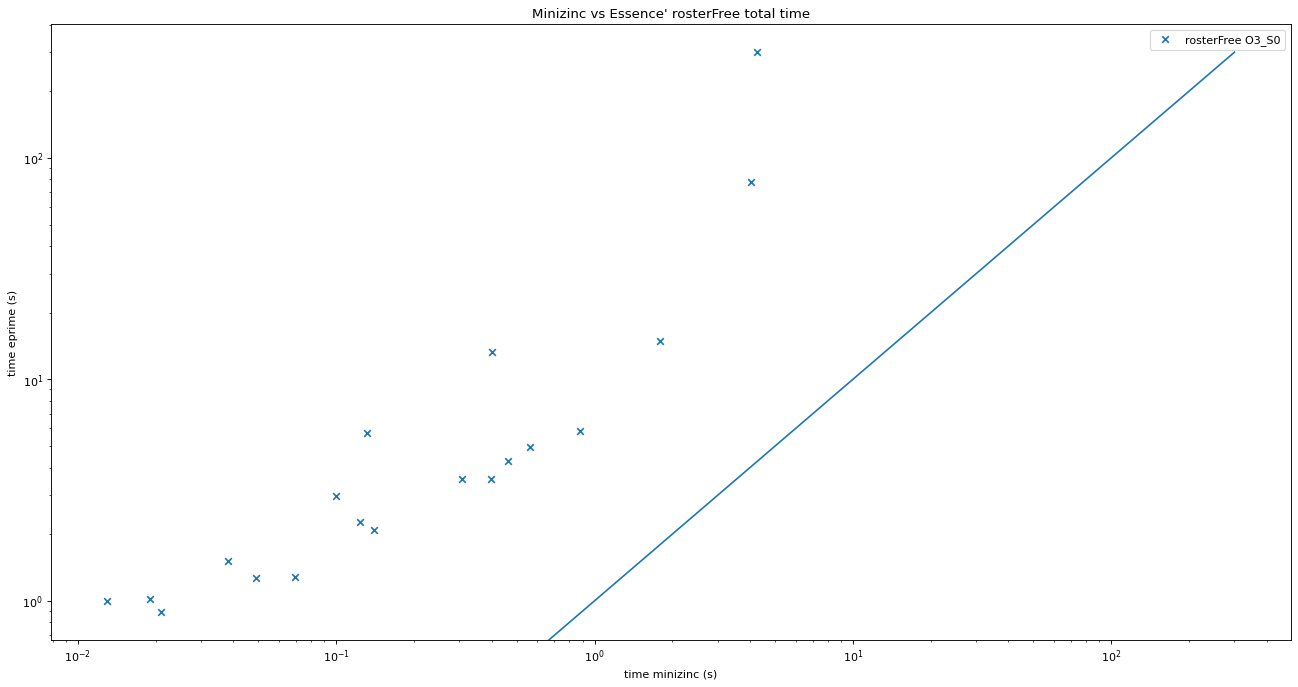

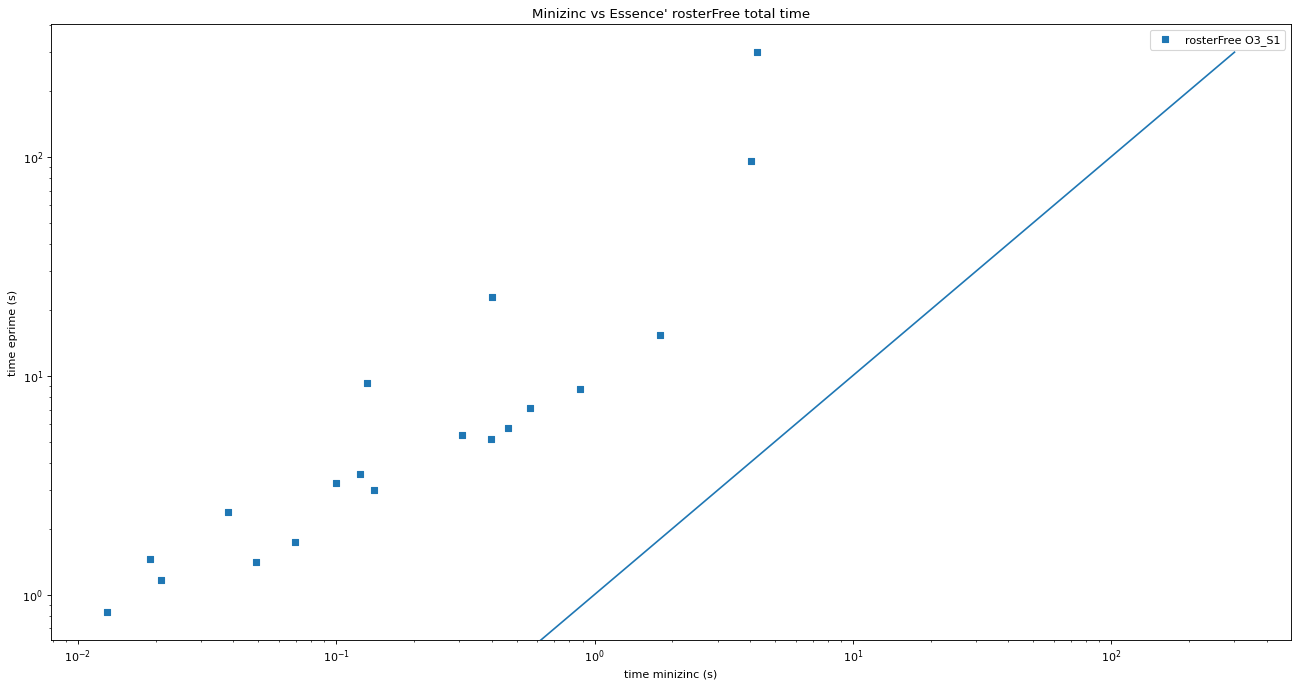

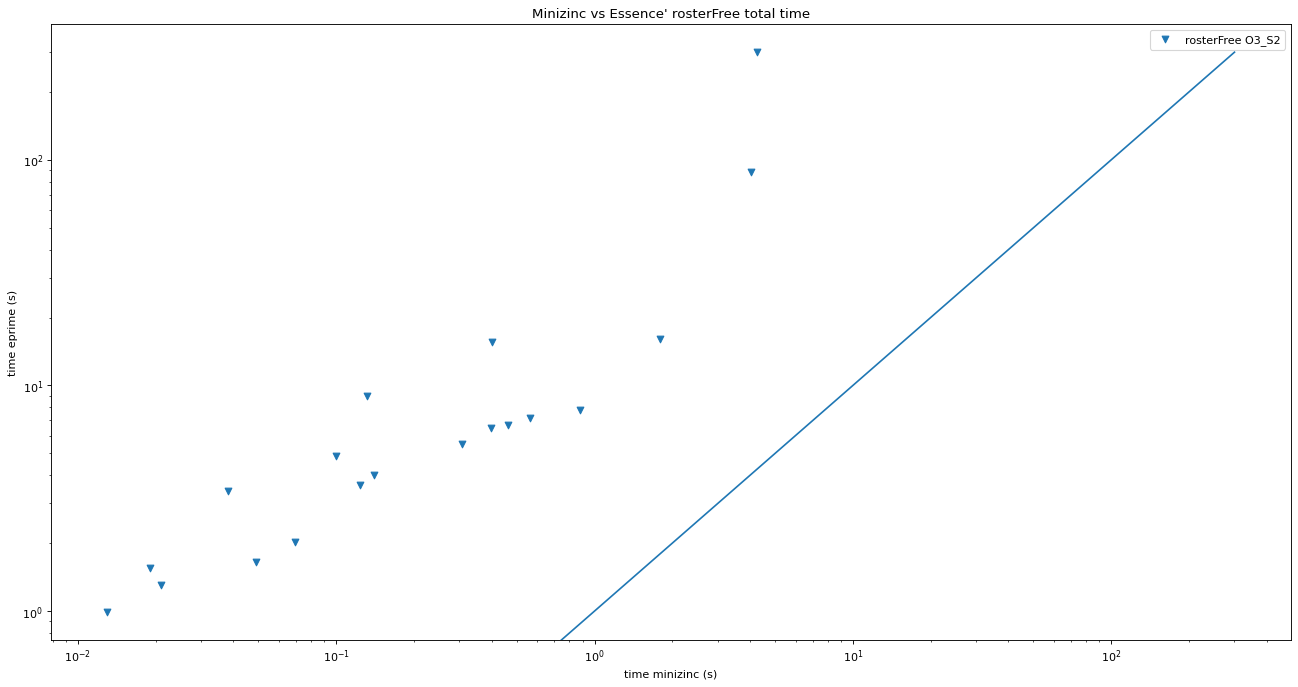

In [245]:
for i in optimisations:
    setupPlotSolverSolver()
    createPlot(i, [rosterFree])
    plt.legend(loc="best")


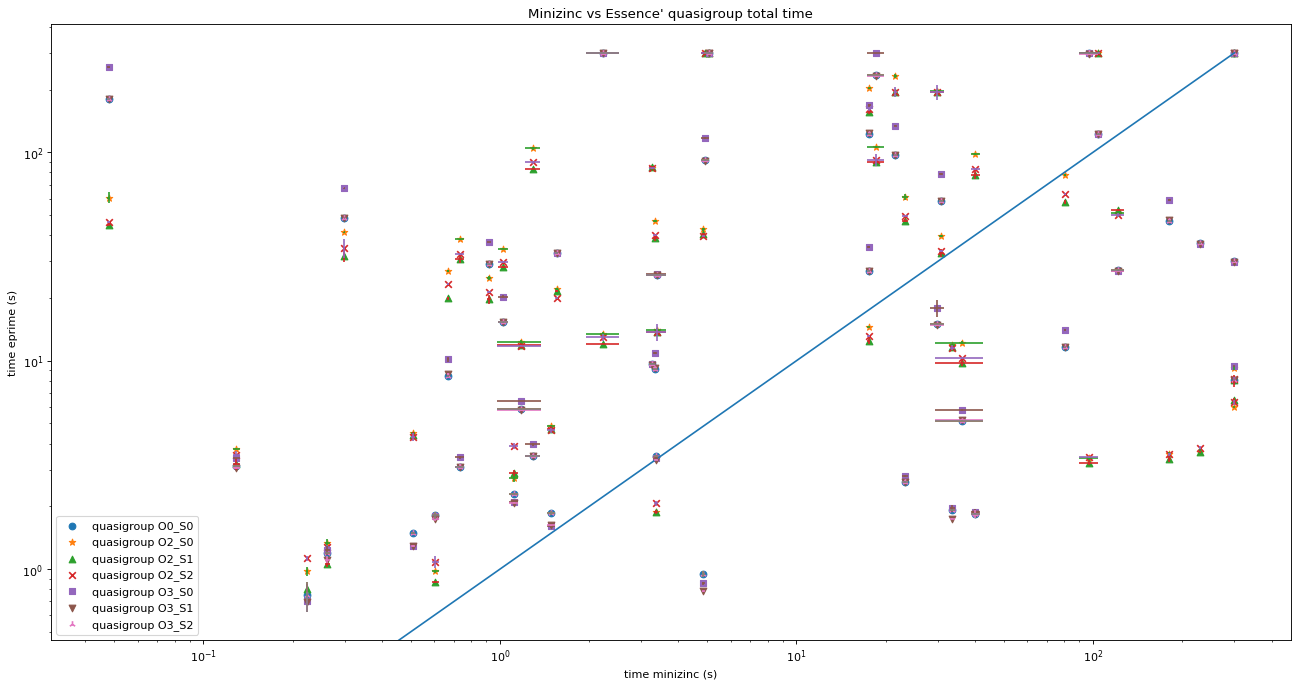

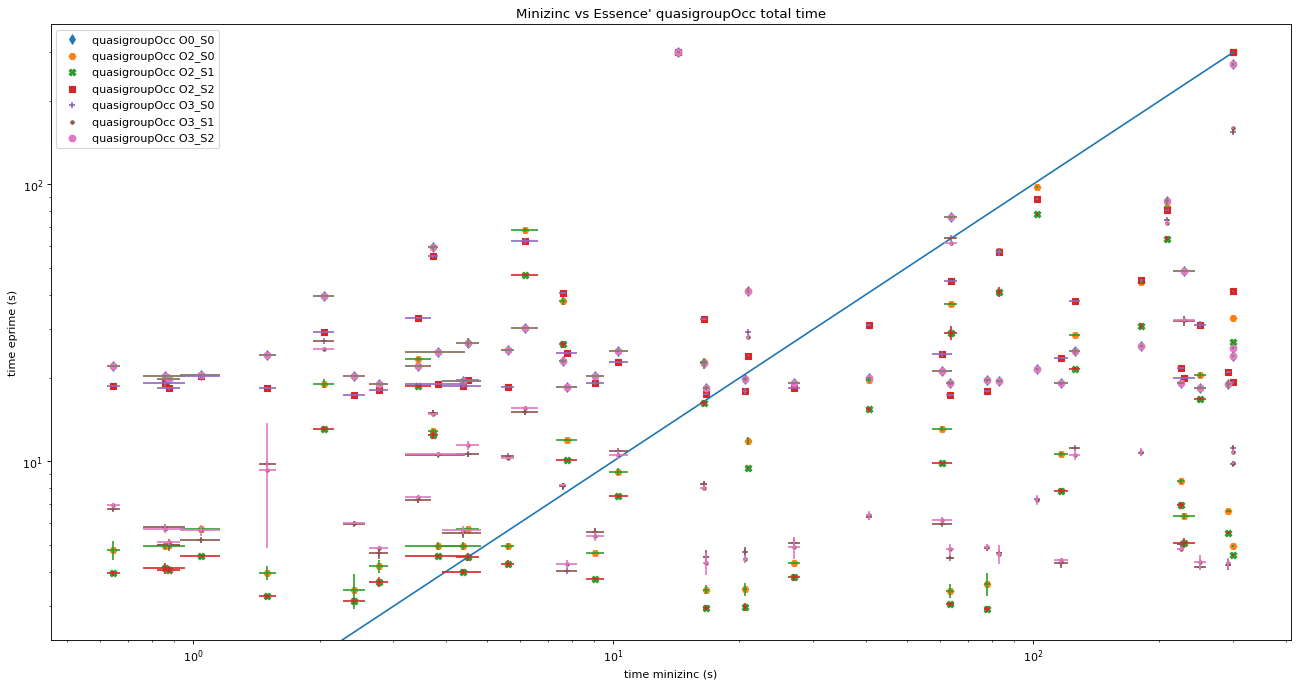

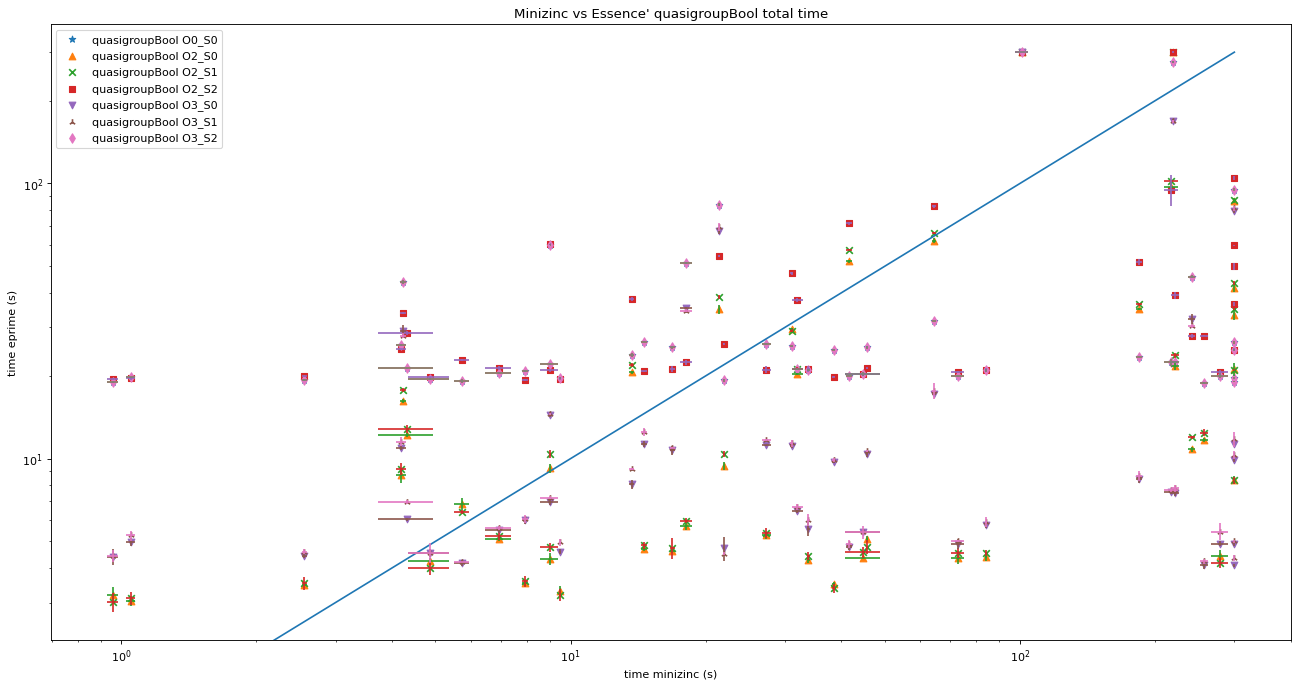

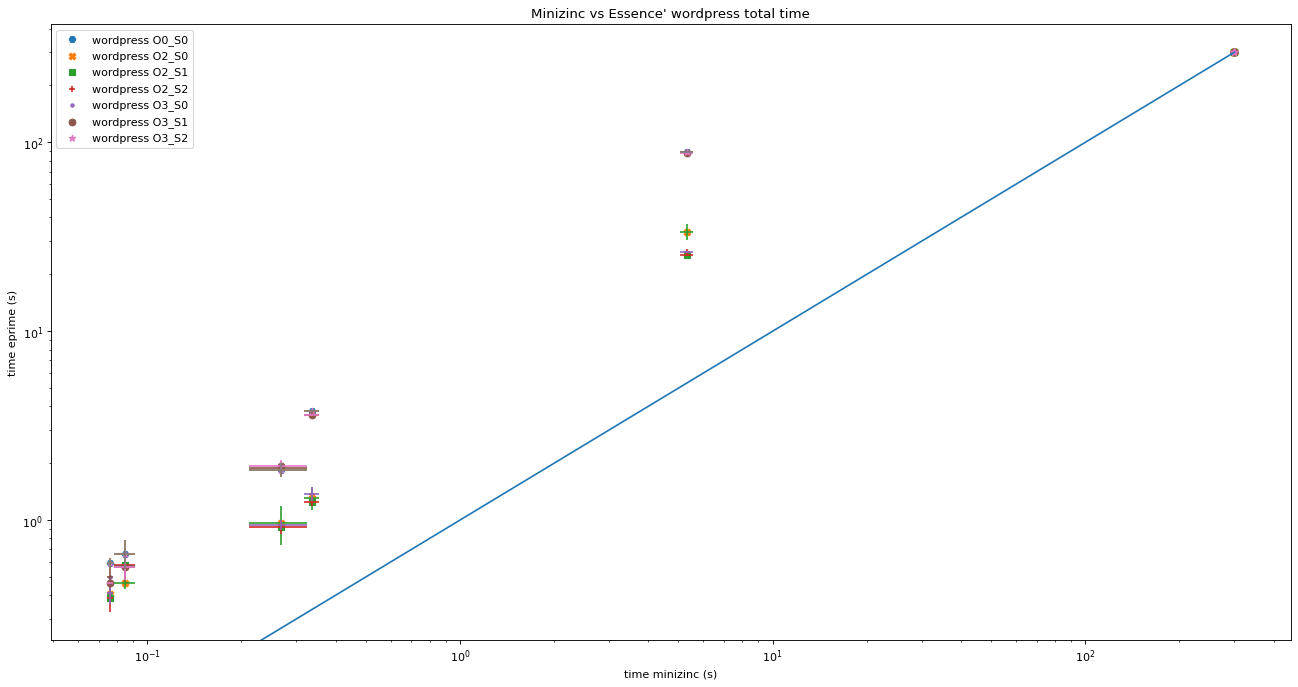

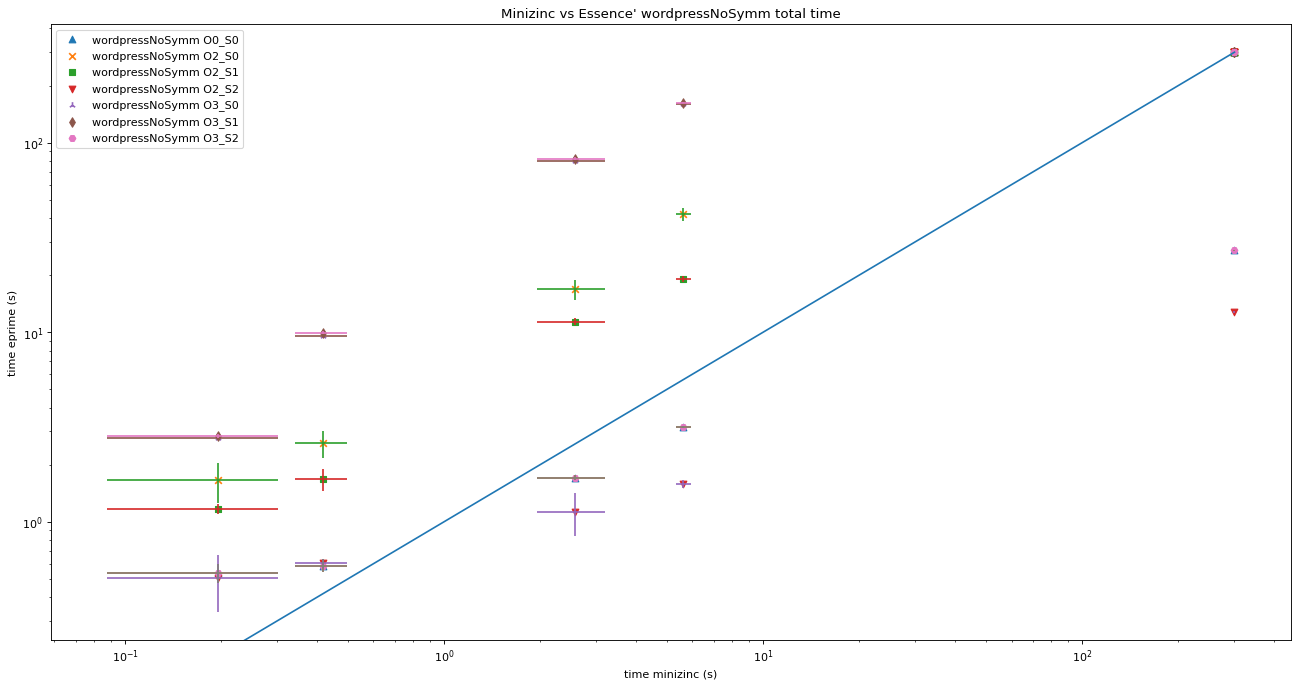

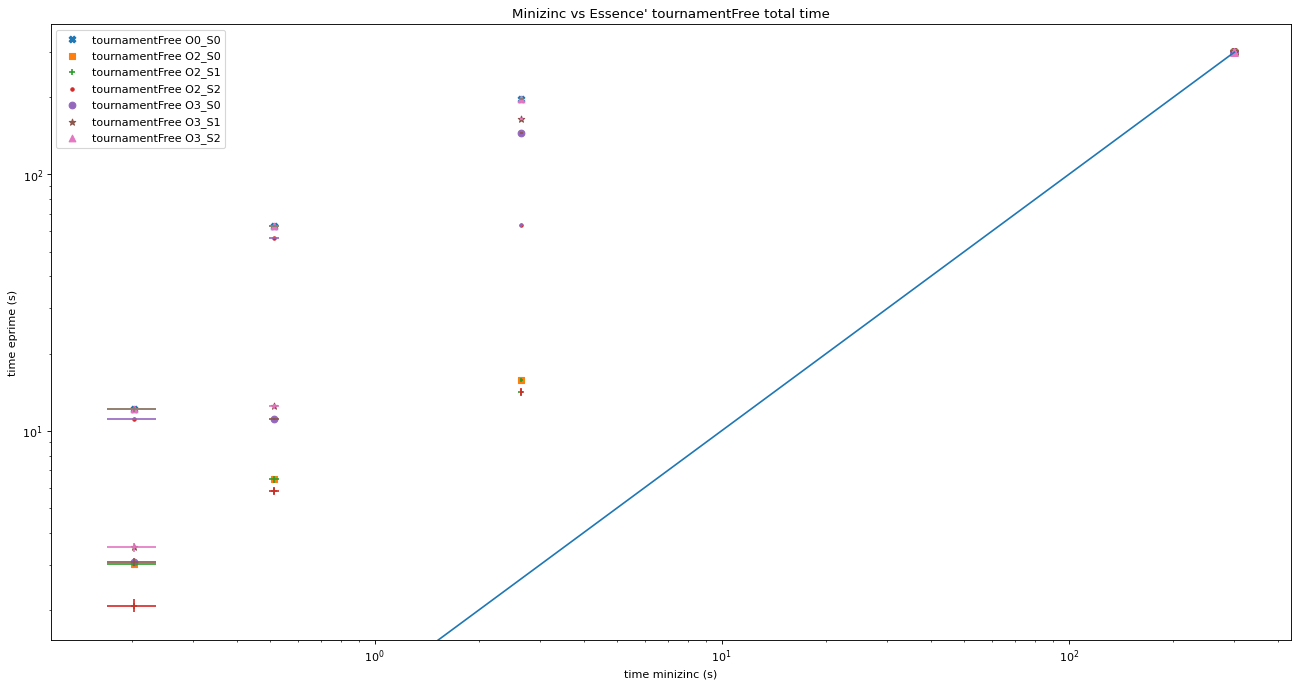

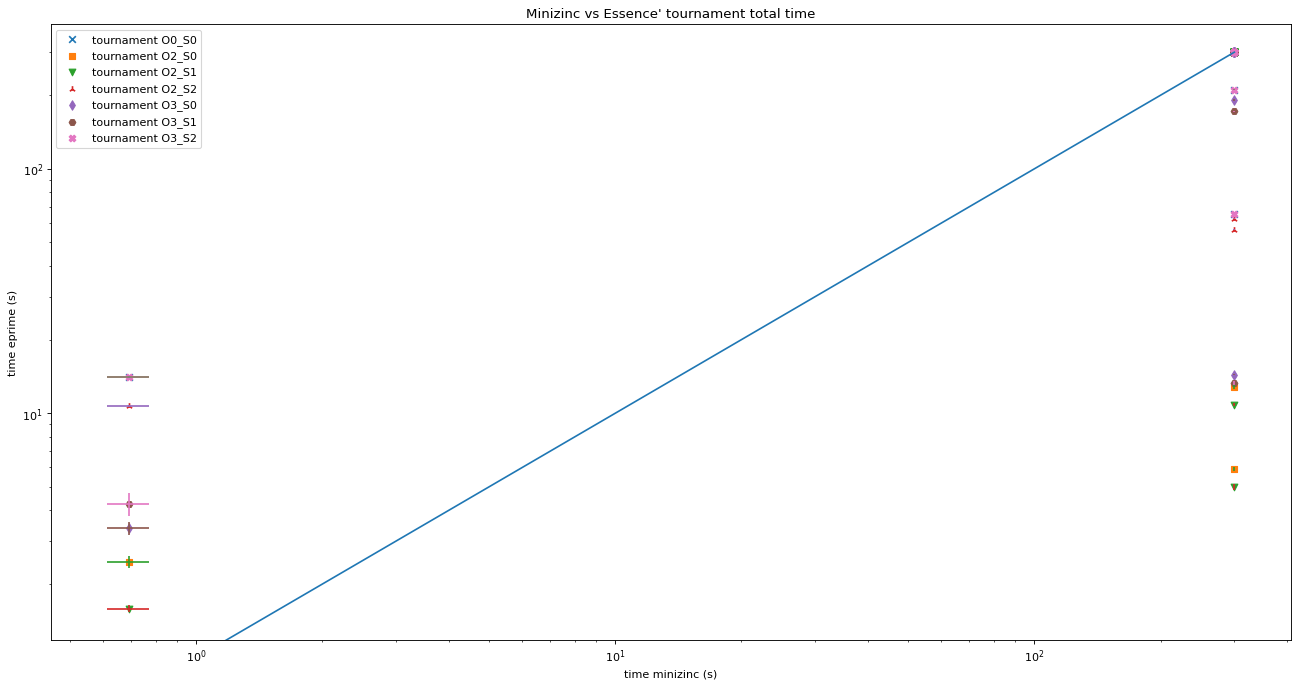

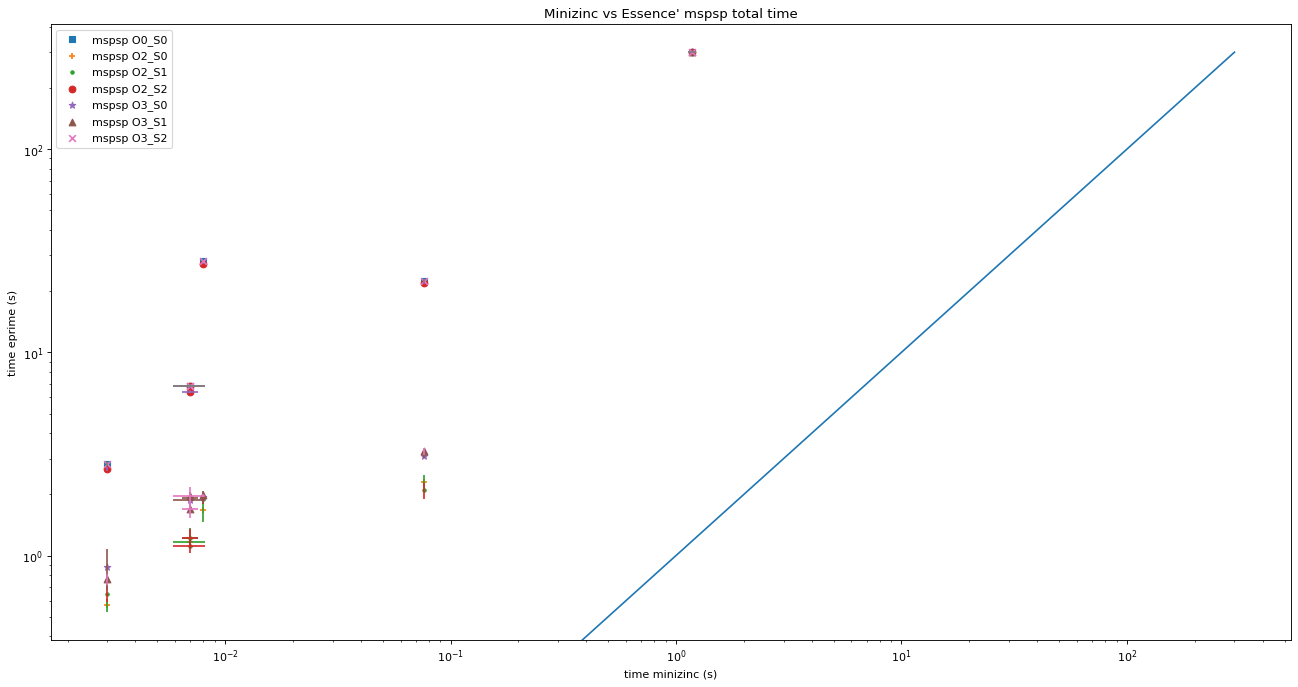

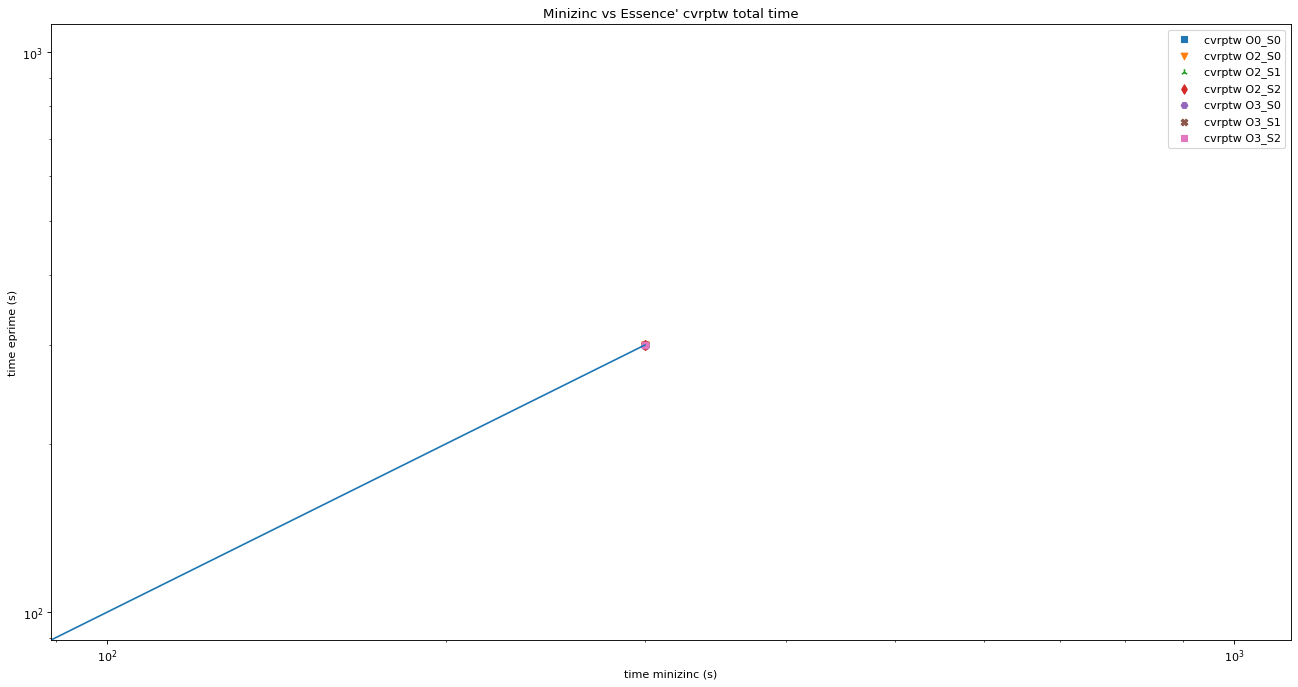

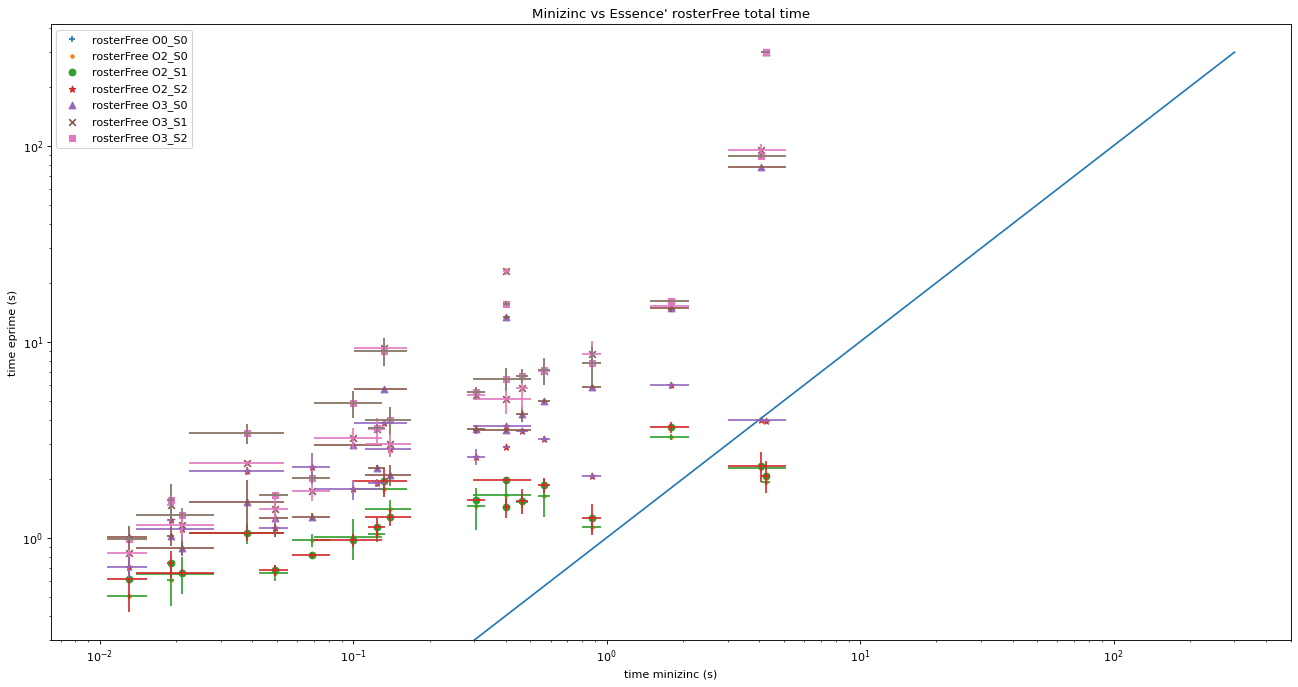

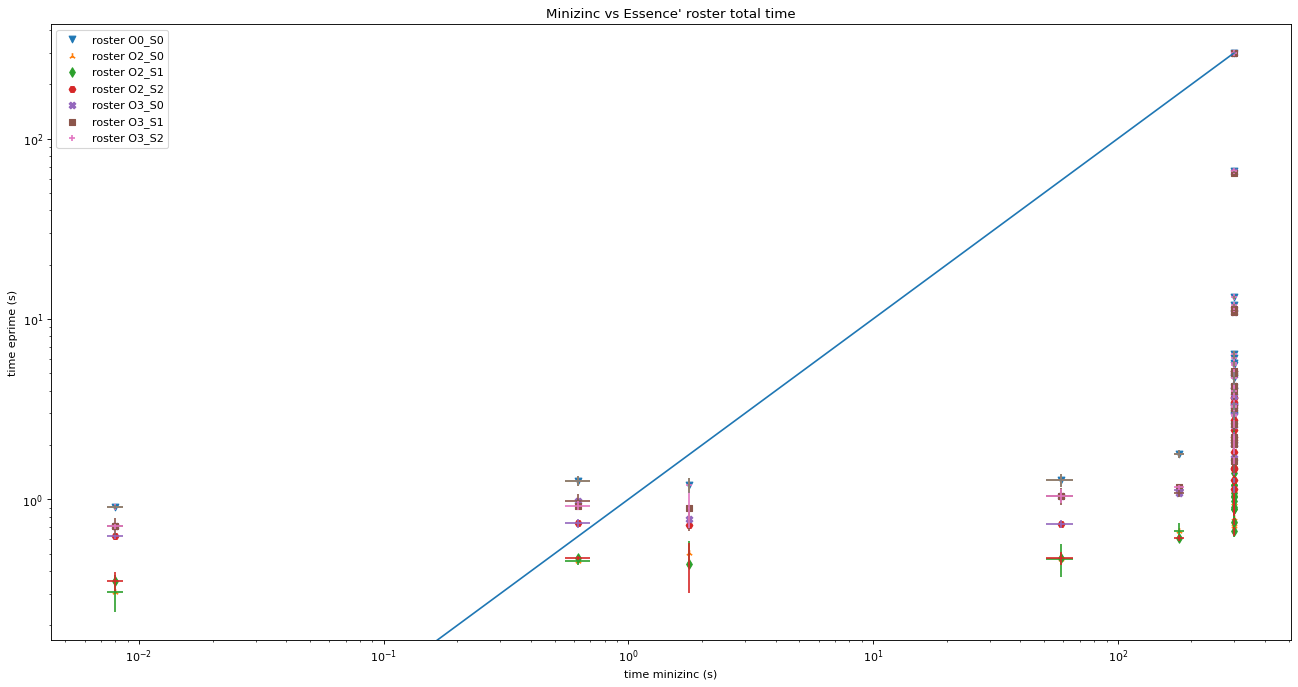

In [254]:
for i in problems:
    setupPlotSolverSolver()
    for j in optimisations:
        createPlot(j, [i], errorbars=True)
    plt.legend(loc="best")

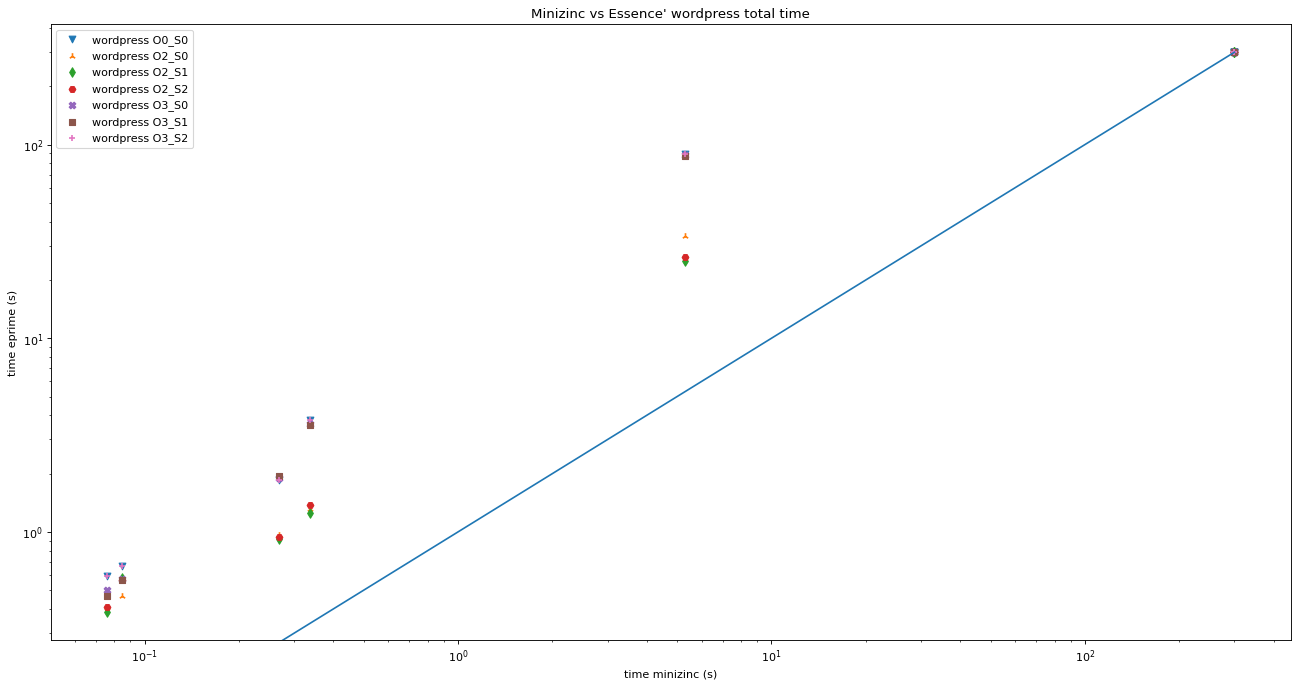

In [247]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpress])
plt.legend(loc="best")

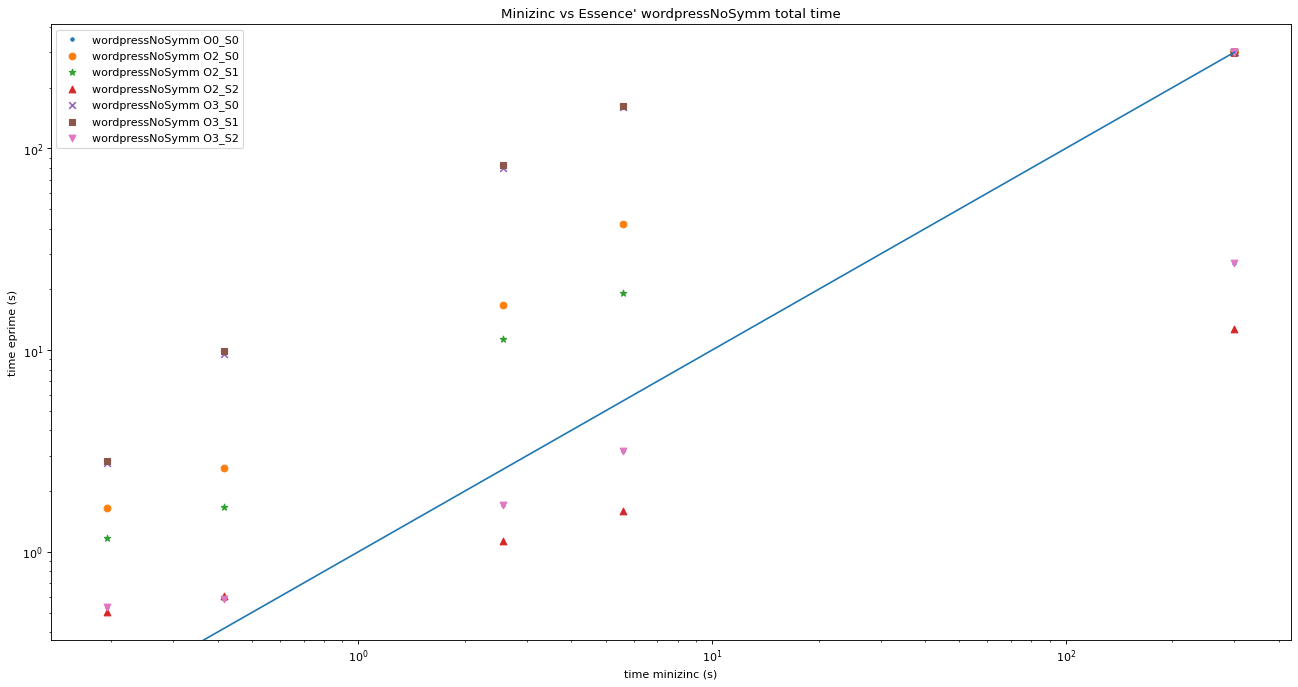

In [248]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [wordpressNoSymm])
plt.legend(loc="best")

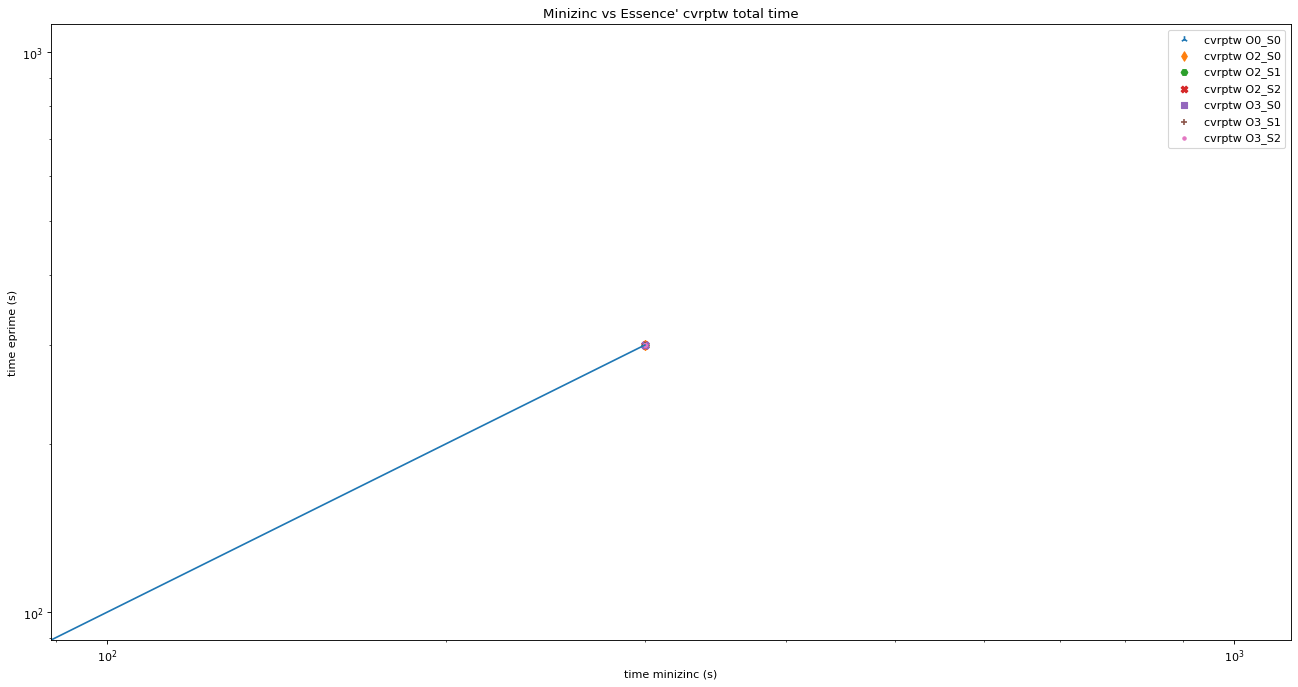

In [249]:
setupPlotSolverSolver()
for j in optimisations:
    createPlot(j, [cvrptw])
plt.legend(loc="best")

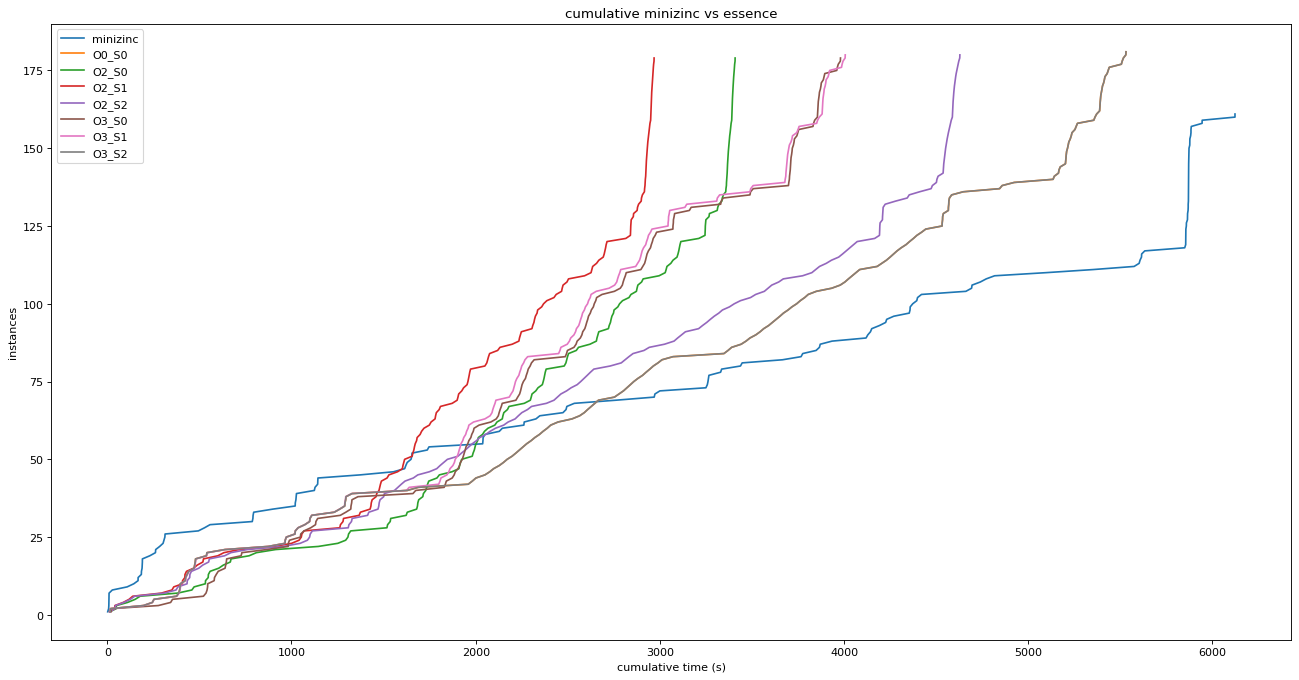

In [250]:
import numpy as np

def setupCumulativePlot(title):
    figure(figsize=(20, 10), dpi=80)
    plt.xlabel("cumulative time (s)")
    plt.ylabel("instances")
    plt.title(title)
    # plt.yscale("log")
    # plt.xscale("log")


# def plotInvValues(xValues, yValues, label):
#     plt.plot(xValues, yValues, label=label)
    # plt.xlim(max(xValues), min(xValues))
    # plt.ylim(max(yValues), min(yValues))

def getTimingCompleted(i, opt=None, std=False):
    indexToGet = timingIndex
    if std:
        indexToGet = stdDevIndex
    if opt != None:
        return allEprimeTimings[i][opt][indexToGet], allEprimeTimings[i][opt][timeoutIndex]
    return allMinizincTimings[i][indexToGet], allMinizincTimings[i][timeoutIndex]


def createCumulativePlot(problemList=problems, opt=None, std=False):
    cumulativeTime = 0.0
    cumulativeInstance = 0
    xValues = []
    # listLenMap = sum([len(allEprimeTimings[j][opt][timingIndex]) for j in problems])
    # yValues = [i for i in range(1, listLenMap+1)]
    yValues = []
    for i in problemList:
        timing, incomplete = getTimingCompleted(i, opt, std)
        for j in range(len(timing)):
            if incomplete[j]:
                continue
            cumulativeTime += timing[j]
            cumulativeInstance += 1
            xValues.append(cumulativeTime)
            yValues.append(cumulativeInstance)
    plt.plot(xValues, yValues, label=opt if opt else "minizinc")
    return xValues, yValues

setupCumulativePlot("cumulative minizinc vs essence")
xValues, yValues = createCumulativePlot()
for opt in optimisations:
# for opt in ["O0_S0"]:
    xEValues, yEValues = createCumulativePlot(opt=opt)
plt.legend(loc="best")

# for opt in optimisations:
    # setupCumulativePlot(opt)
    # createCumulativePlot(opt)


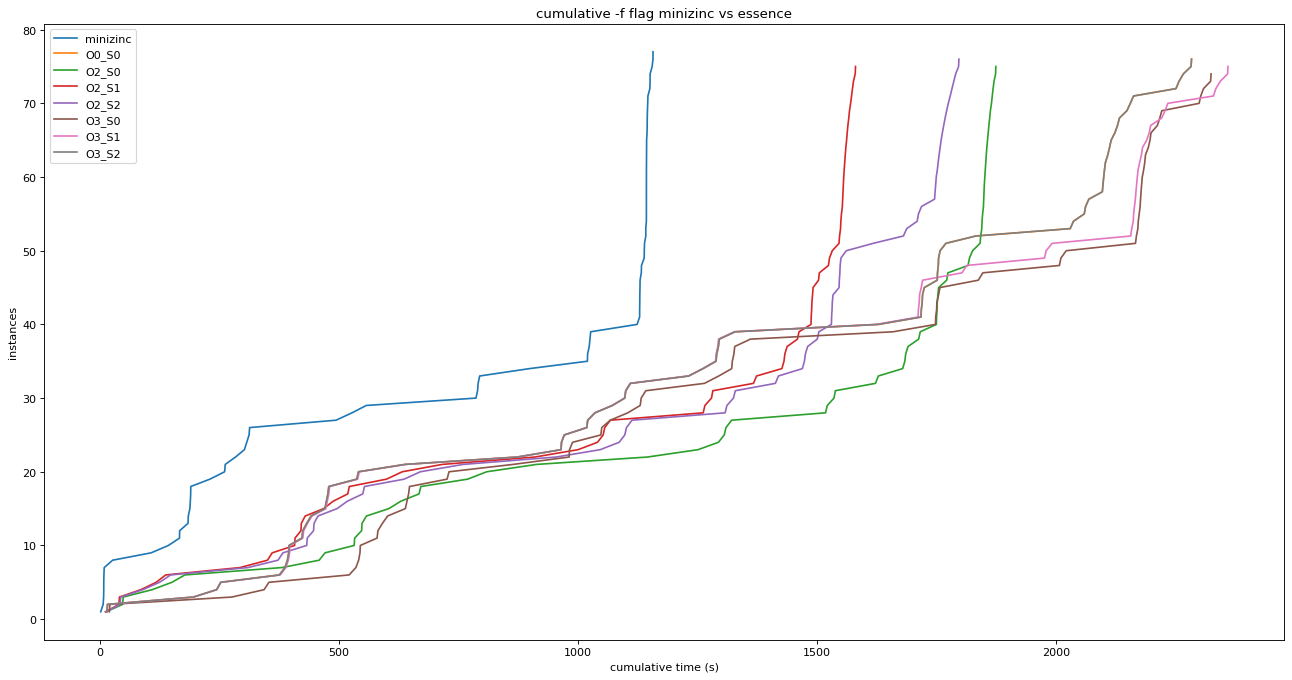

In [251]:
setupCumulativePlot("cumulative -f flag minizinc vs essence")
xValues, yValues = createCumulativePlot(problemList=freeOriginalProblems)
for opt in optimisations:
# for opt in ["O0_S0"]:
    xEValues, yEValues = createCumulativePlot(problemList=freeOriginalProblems, opt=opt)
plt.legend(loc="best")

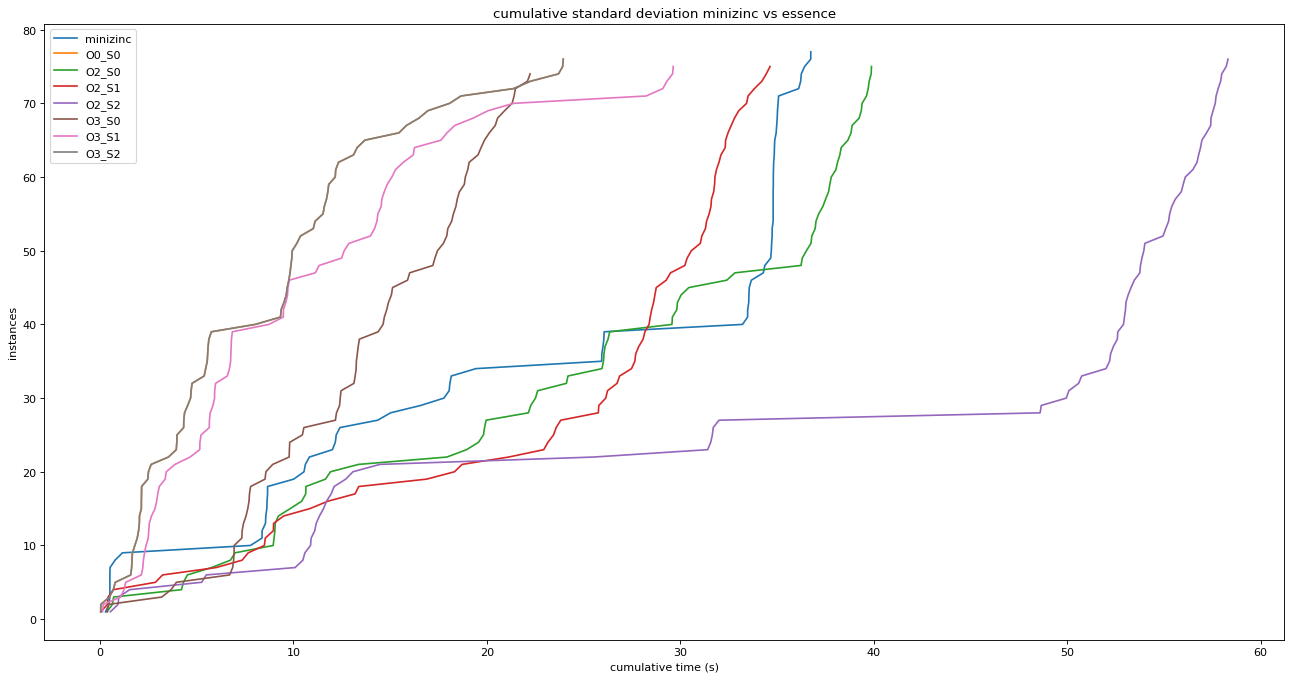

In [252]:
setupCumulativePlot("cumulative standard deviation minizinc vs essence")
xValues, yValues = createCumulativePlot(problemList=freeOriginalProblems, std=True)
for opt in optimisations:
# for opt in ["O0_S0"]:
    xEValues, yEValues = createCumulativePlot(problemList=freeOriginalProblems, opt=opt, std=True)
plt.legend(loc="best")

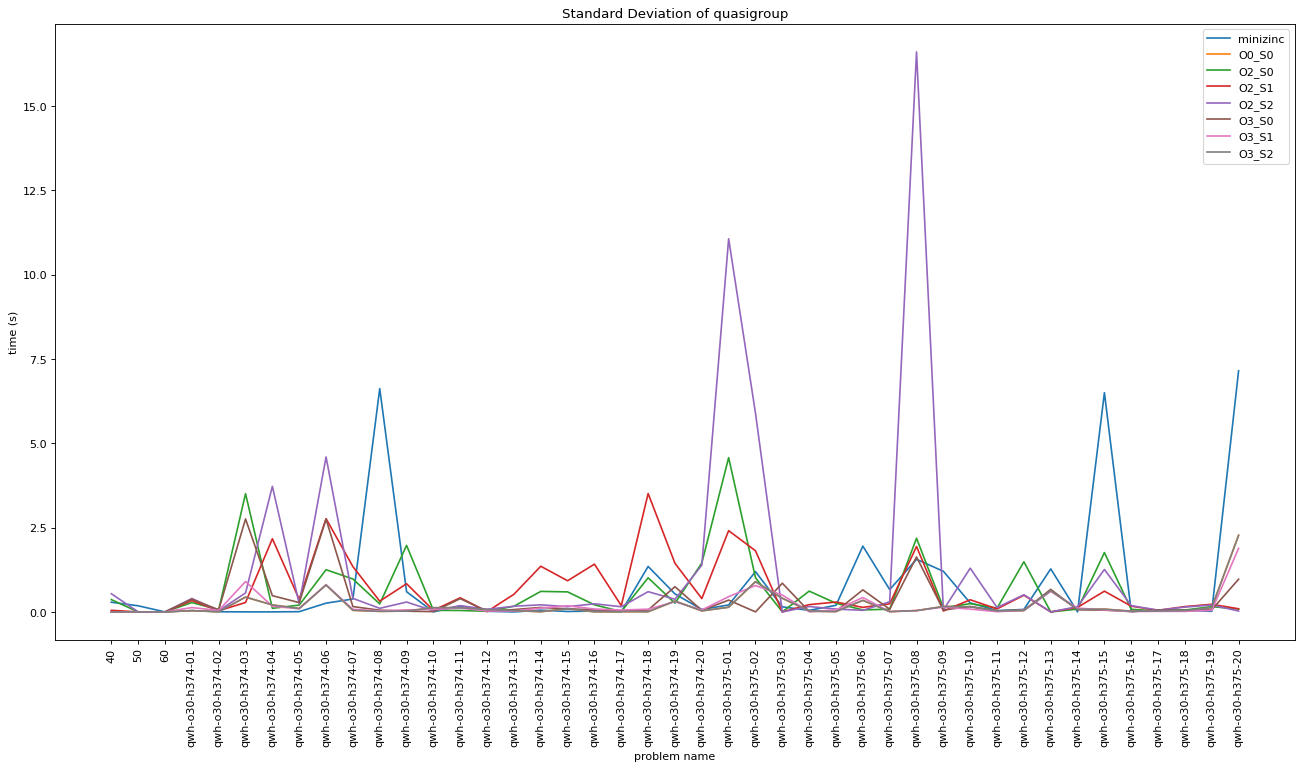

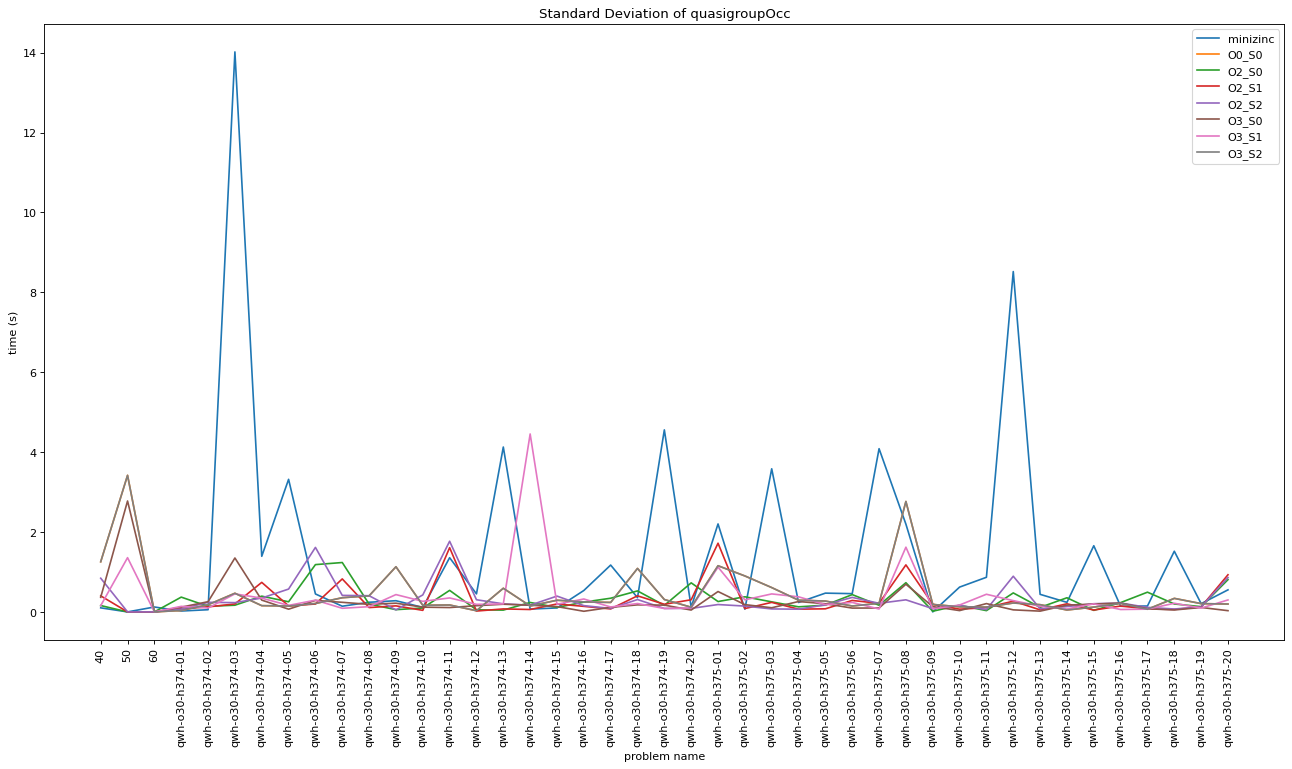

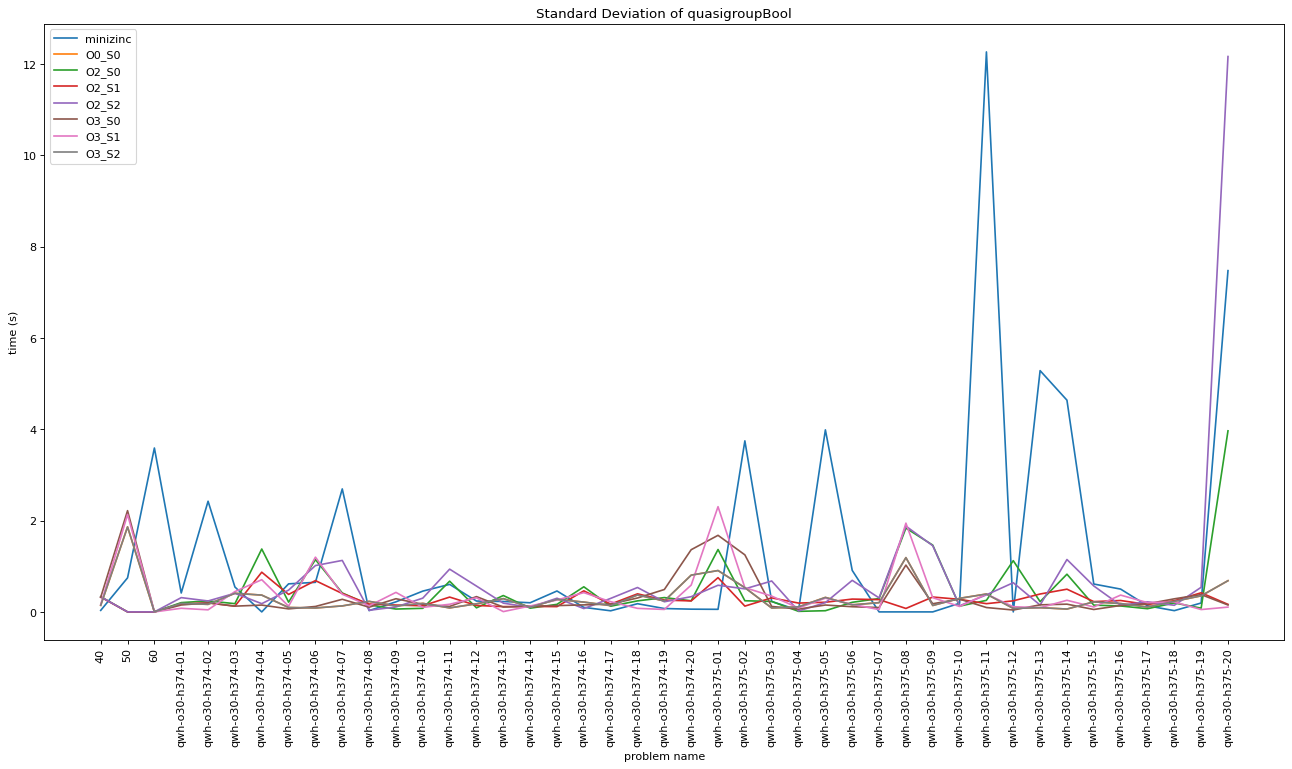

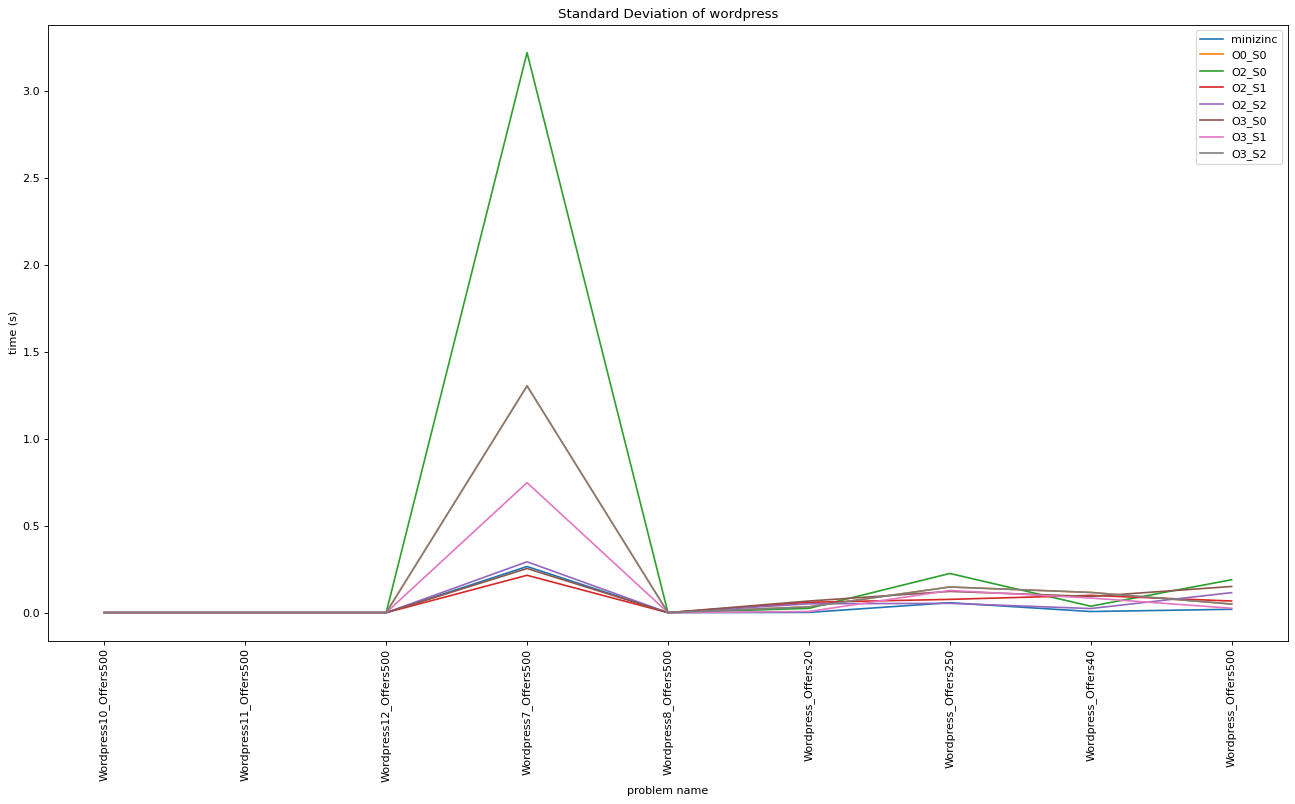

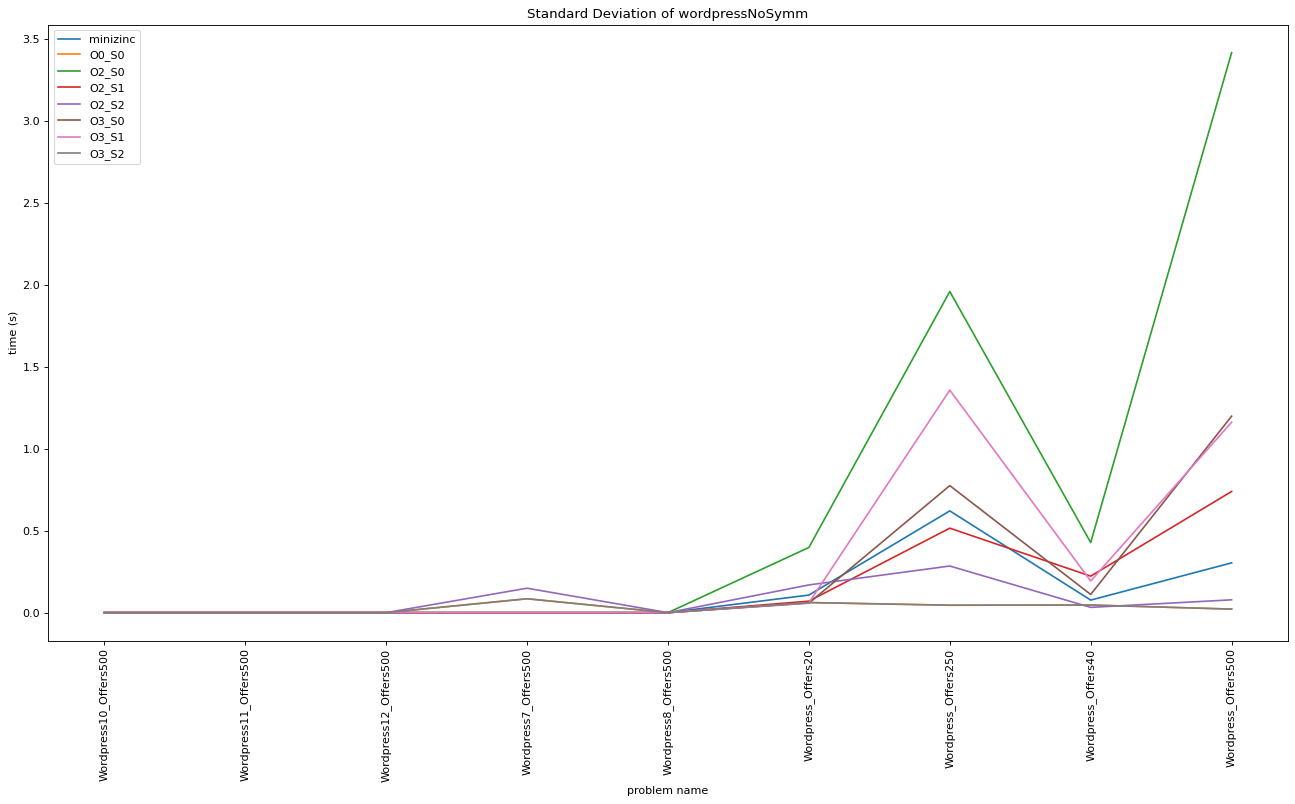

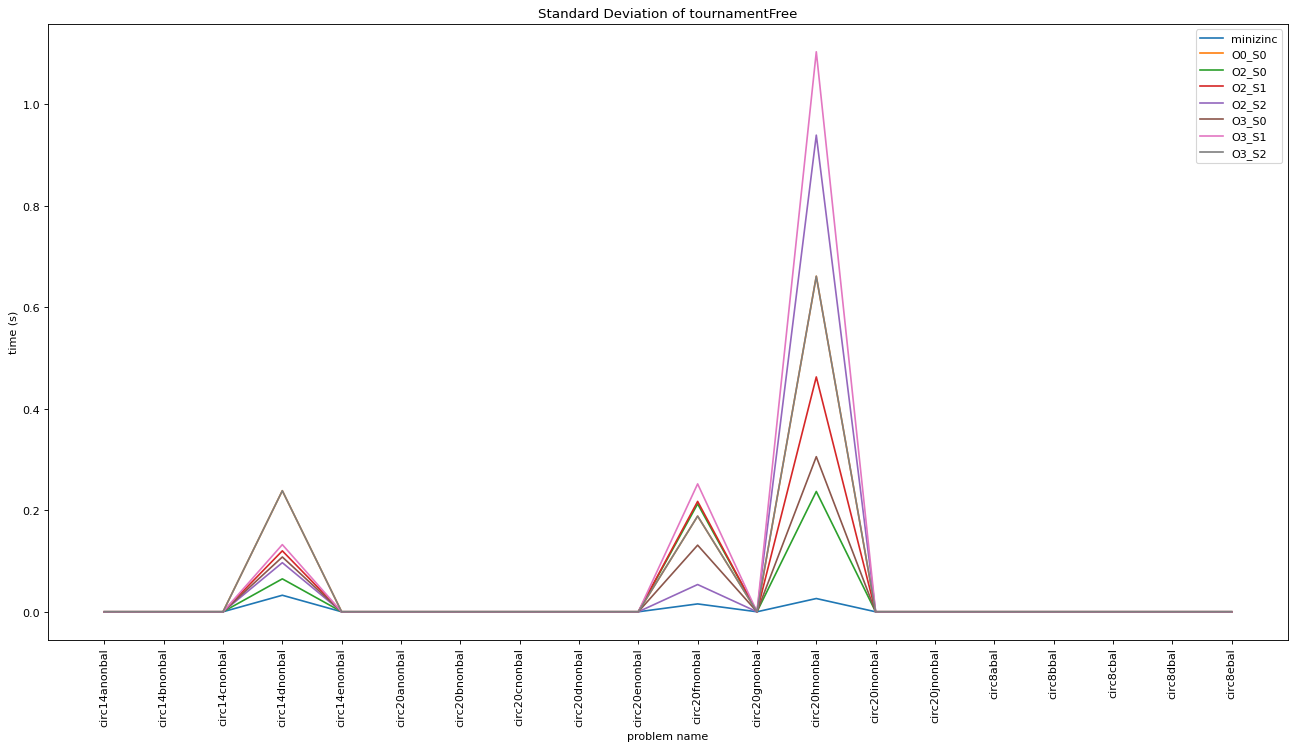

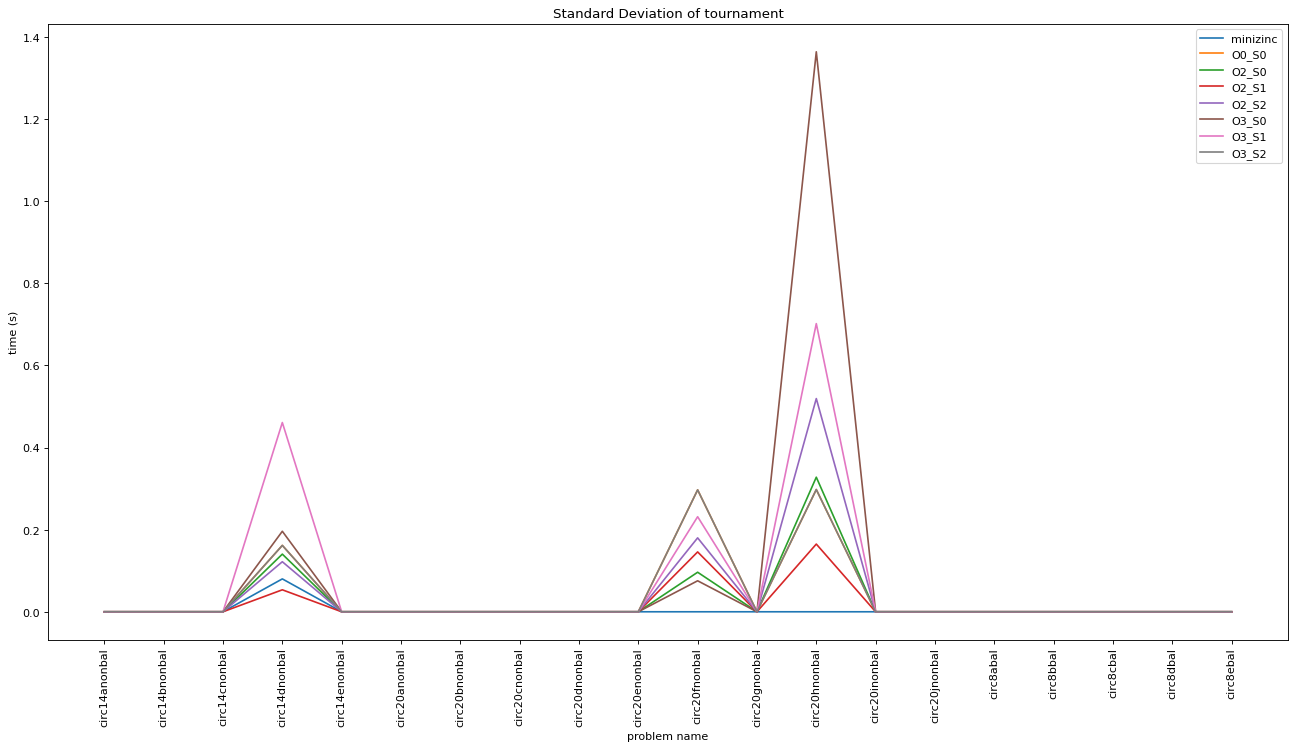

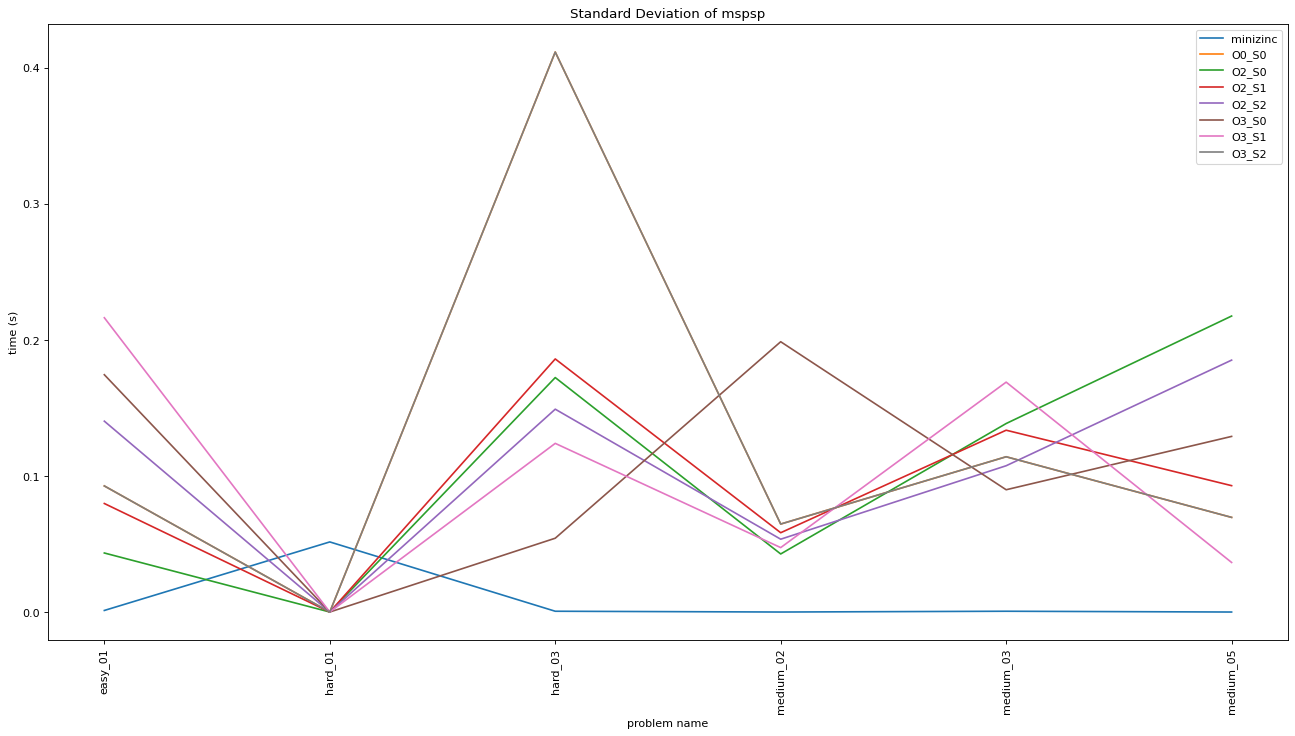

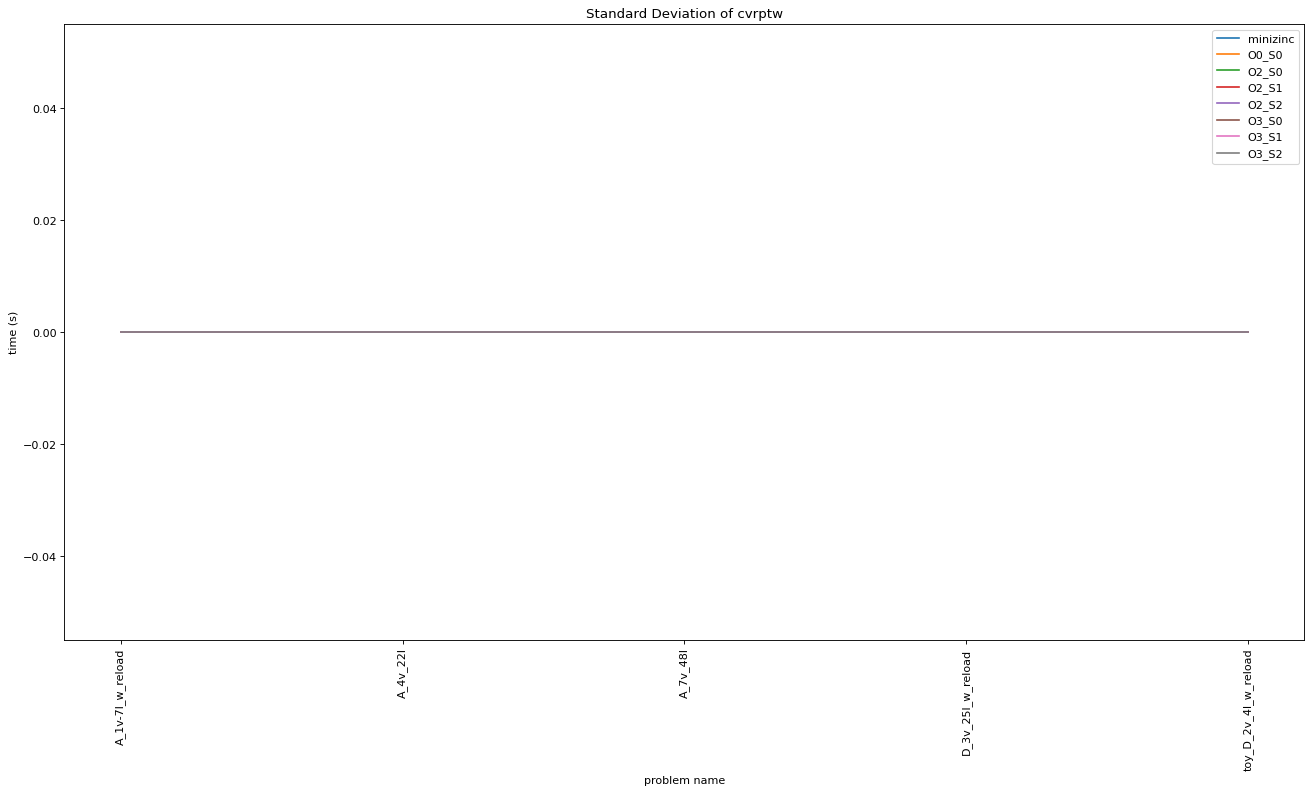

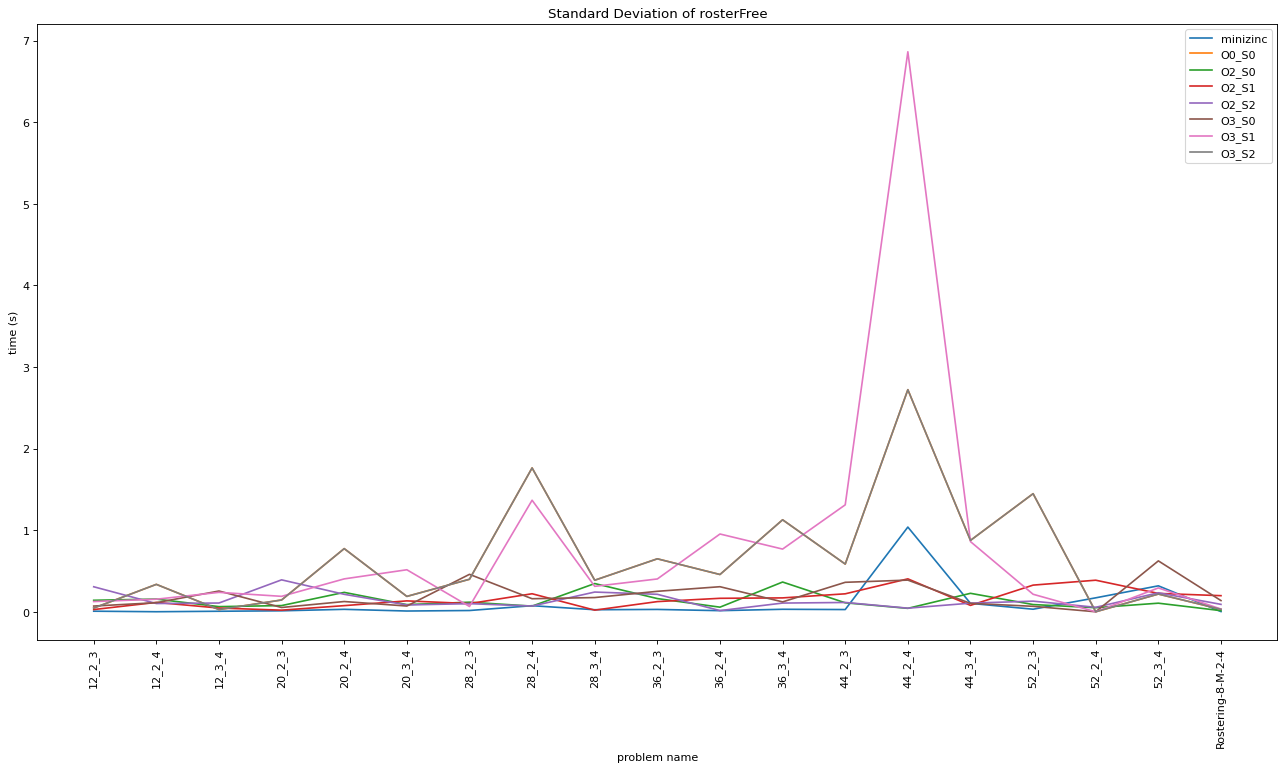

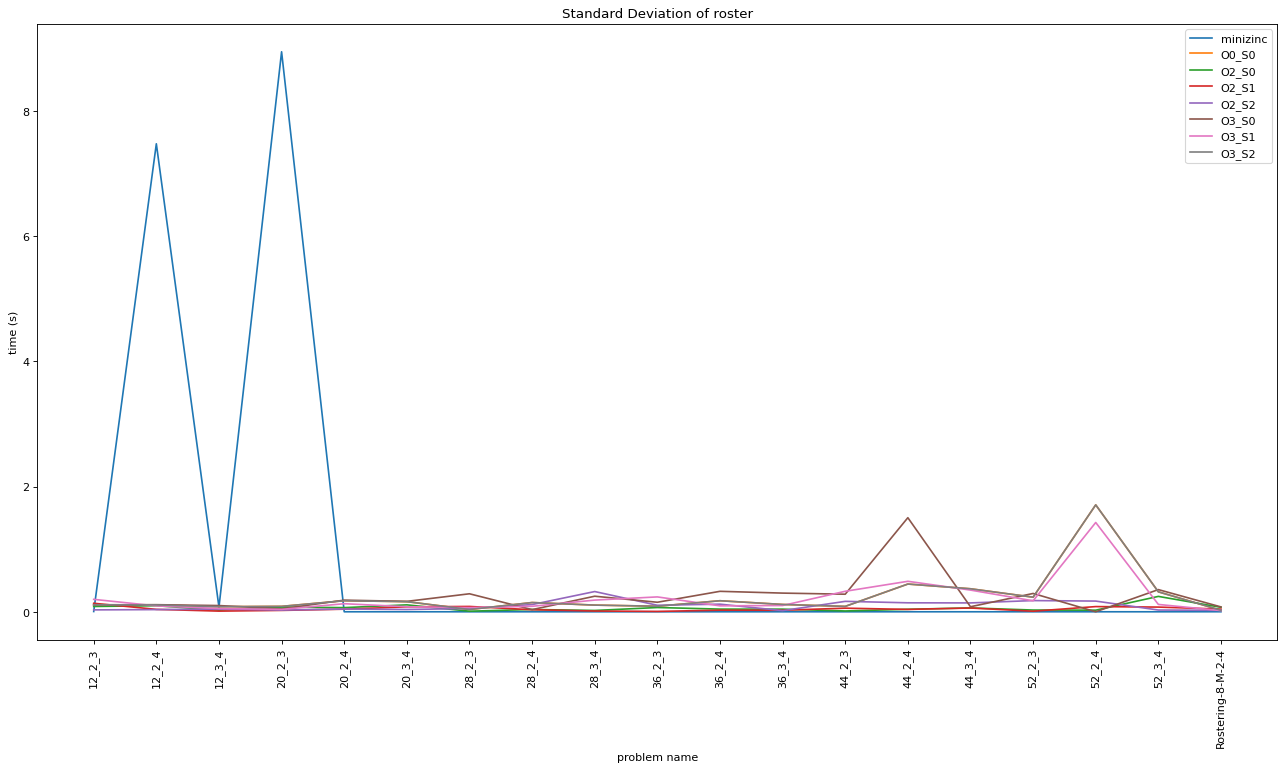

In [253]:
def setupStdPlot(title):
    figure(figsize=(20, 10), dpi=80)
    plt.xlabel("problem name")
    plt.ylabel("time (s)")
    plt.xticks(rotation = 90)
    plt.title(title)

def plotStd(toGraph, opt=None):
    xVals, yVals = toGraph[problemIndex], toGraph[stdDevIndex]
    xVals = [i.split(".")[0] for i in xVals]
    plt.plot(xVals, yVals, label=opt if opt else "minizinc")

for problem in problems:
    setupStdPlot("Standard Deviation of " + problem)
    plotStd(allMinizincTimings[problem])
    for opt in optimisations:
    # for opt in ["O0_S0"]:
        plotStd(allEprimeTimings[problem][opt], opt=opt)
    plt.legend(loc="best")
    